# Comprehensive Data Analysis and Logistic Regression Modeling

## Introduction
In this notebook, we perform data analysis to understand the dataset and then build and evaluate a logistic regression model to predict loan status.

### 1.1 Descriptive Statistics

Using the `describe` method, we assess the central tendencies and spread of each variable in the dataset. This includes:

- **Count**: Number of non-null entries for each column.
- **Mean**: The average value of each feature.
- **Standard Deviation (std)**: Measures the dispersion or spread of the data.
- **Minimum (min)**: The smallest value in the dataset.
- **25th Percentile (25%)**: The value below which 25% of the data falls.
- **Median (50%)**: The middle value separating the higher half from the lower half.
- **75th Percentile (75%)**: The value below which 75% of the data falls.
- **Maximum (max)**: The largest value in the dataset.

By examining these statistics, we can identify any potential issues with the data, such as outliers, unusual minimum or maximum values, or large deviations that might affect model performance.



In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from ISLP import confusion_table


df = pd.read_csv('../../data/processed/credit_risk_dataset_processed.csv')

print(df.head())

print(df.describe())

   person_age  person_income person_home_ownership  person_emp_length  \
0          21           9600                   OWN                5.0   
1          25           9600              MORTGAGE                1.0   
2          23          65500                  RENT                4.0   
3          24          54400                  RENT                8.0   
4          21           9900                   OWN                2.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0   EDUCATION          B       1000          11.14            0   
1     MEDICAL          C       5500          12.87            1   
2     MEDICAL          C      35000          15.23            1   
3     MEDICAL          C      35000          14.27            1   
4     VENTURE          A       2500           7.14            1   

   loan_percent_income  person_credit_default  person_credit_history  
0                 0.10                      0                      2  
1               

To ensure proper analysis, we separated the dataset into numerical and categorical features. This allowed us to perform relevant statistical analyses and generate appropriate visualizations for each feature type.


In [2]:
numeric_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'person_credit_history']

categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade','person_credit_default']



## Data Distribution Insights

These histograms illustrate the distribution of values for each numerical feature, providing insights into their frequency and spread across the dataset.

It’s important to note that there is significant imbalance in the dataset across features' distributions. This imbalance can potentially affect the model's results, introducing bias towards the more frequent values and potentially impacting the generalization of the model's predictions.


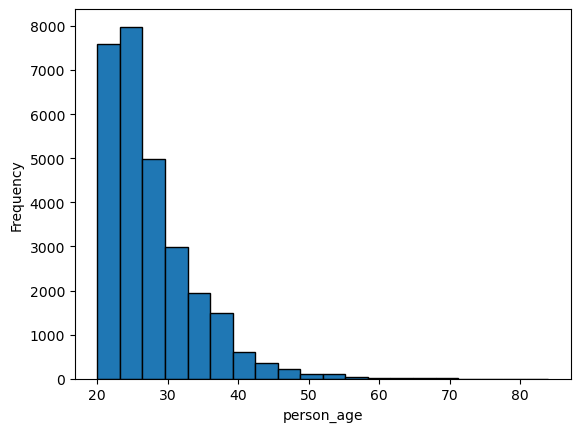

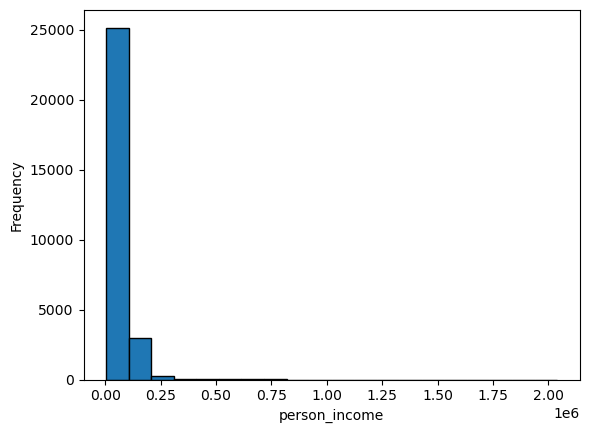

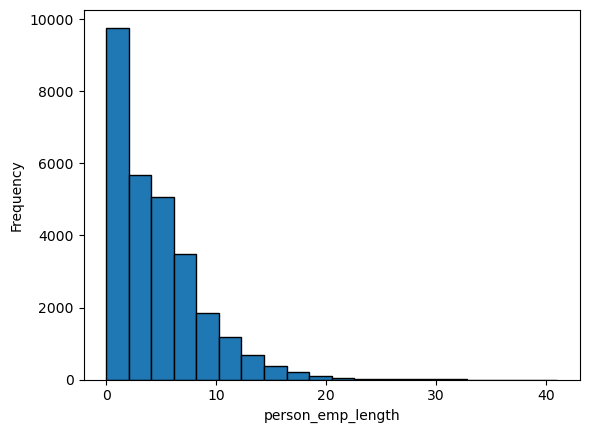

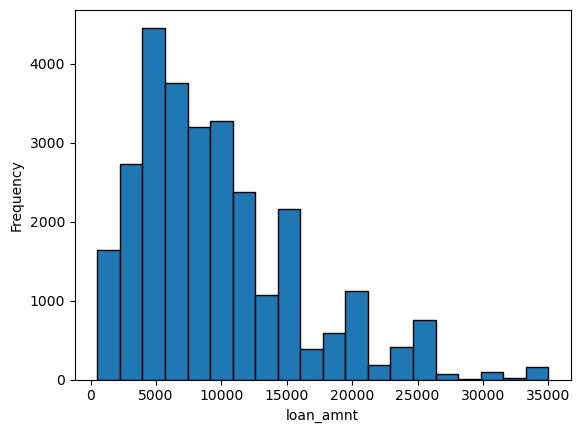

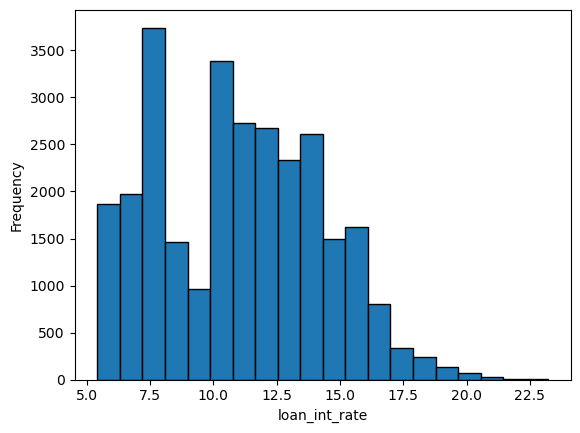

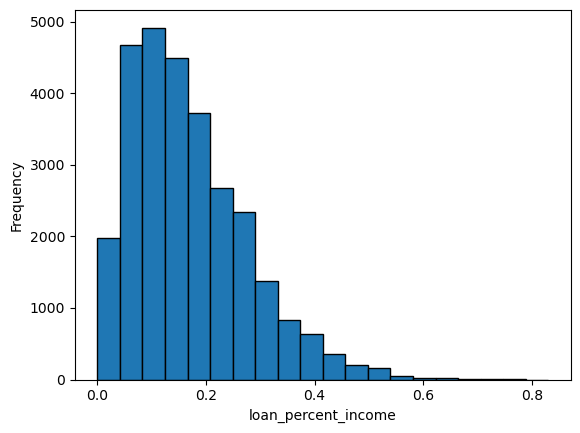

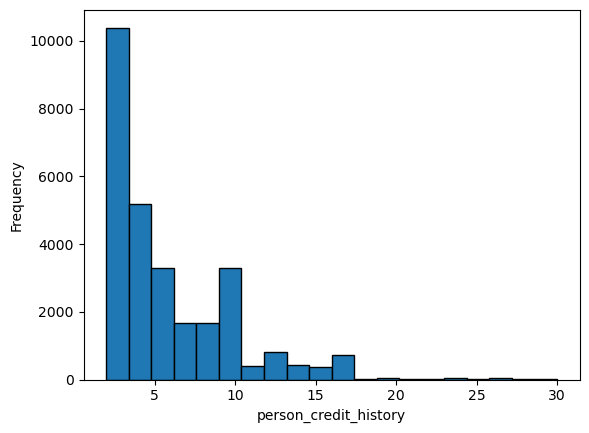

In [3]:
for feature in numeric_features:
    plt.hist(df[feature], bins=20, edgecolor='black')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()


## Outliers

In analyzing our dataset, we encountered potential outliers across several key features such as age and interest rates. It's crucial to recognize that outliers often represent genuine data points reflecting extreme but plausible scenarios. Removing outliers can introduce bias and undermine the model's ability to generalize to diverse real-world situations. 
Therefore, we opted to retain these outliers to ensure our model remains robust and can handle a wide range of conditions.Additionally, during the preprocessing phase, records with an age greater than 100 and emlployment length > 50 were noticed and filtered out to maintain data integrity.


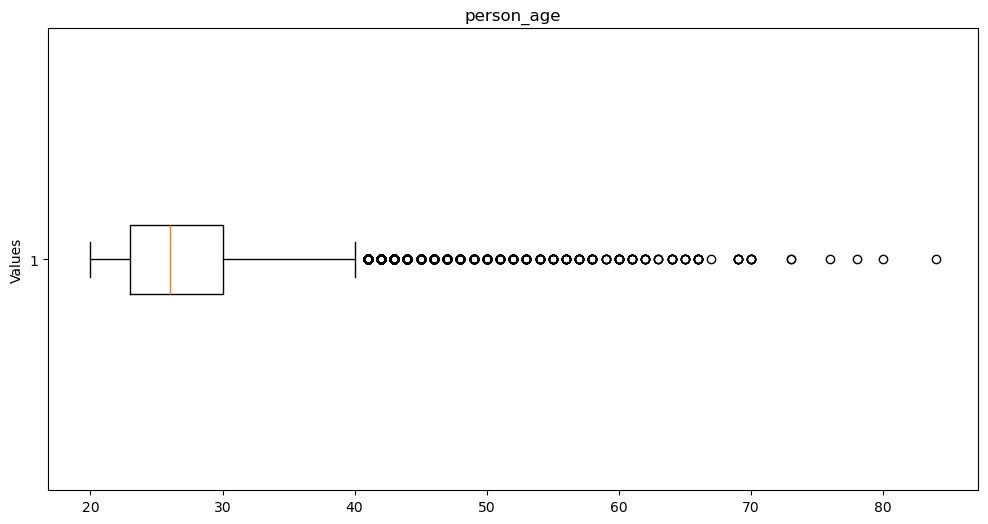

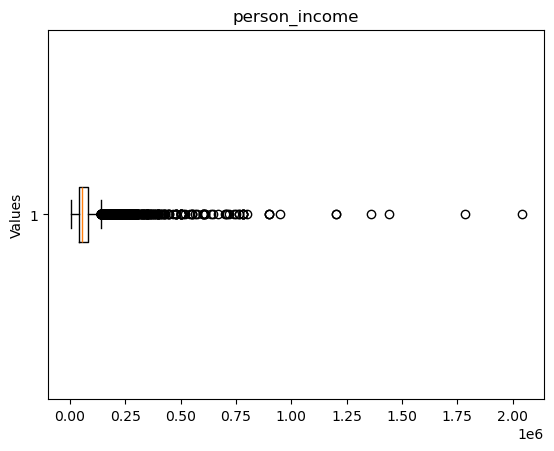

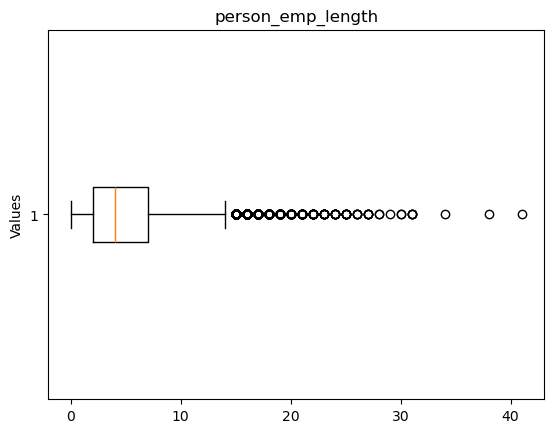

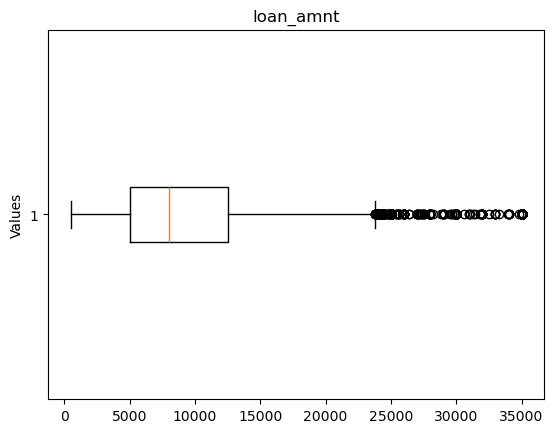

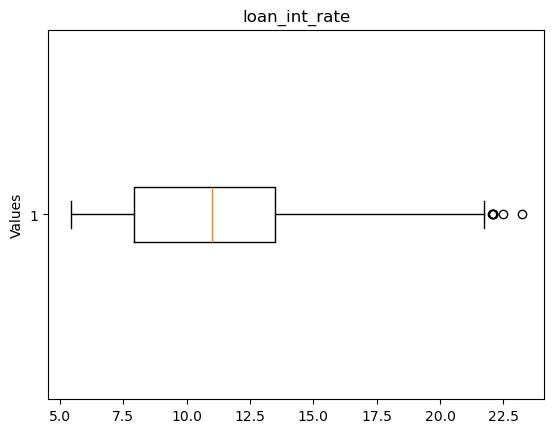

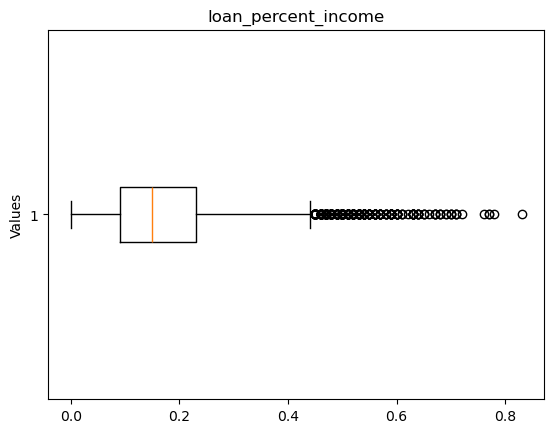

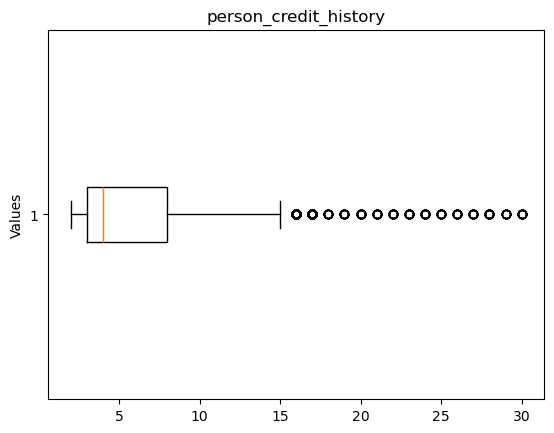

In [103]:
plt.figure(figsize=(12, 6))

for feature in numeric_features:
    plt.boxplot(df[feature],vert=False)
    plt.title(feature)
    plt.ylabel('Values')
    plt.show()



## Analysis of Loan Status Across Numerical Features

The below histograms display the count of defaults vs. non-defaults within each numerical feature, grouped by their respective value ranges.

From the histograms depicting each feature versus loan status counts, a notable trend emerges: as the 'loan_int_rate' or 'loan_percent_income' increases, the proportion of defaults (depicted by the yellow line) also rises, eventually meeting the non-defaults (blue line) at higher values. Beyond this point, the number of default cases begins to exceed non-defaults as loan interest rates and income ratios increase. This observation suggests that these predictors likely play a significant role in influencing default status. In contrast, for features like age, where the lines run parallel without meeting or diverging, these factors may not exert a significant influence on default probability.

This observation underscores the significance of including 'loan_int_rate' and 'loan_percent_income' as critical predictors in our model, suggesting they play a pivotal role in predicting and understanding loan default behavior.


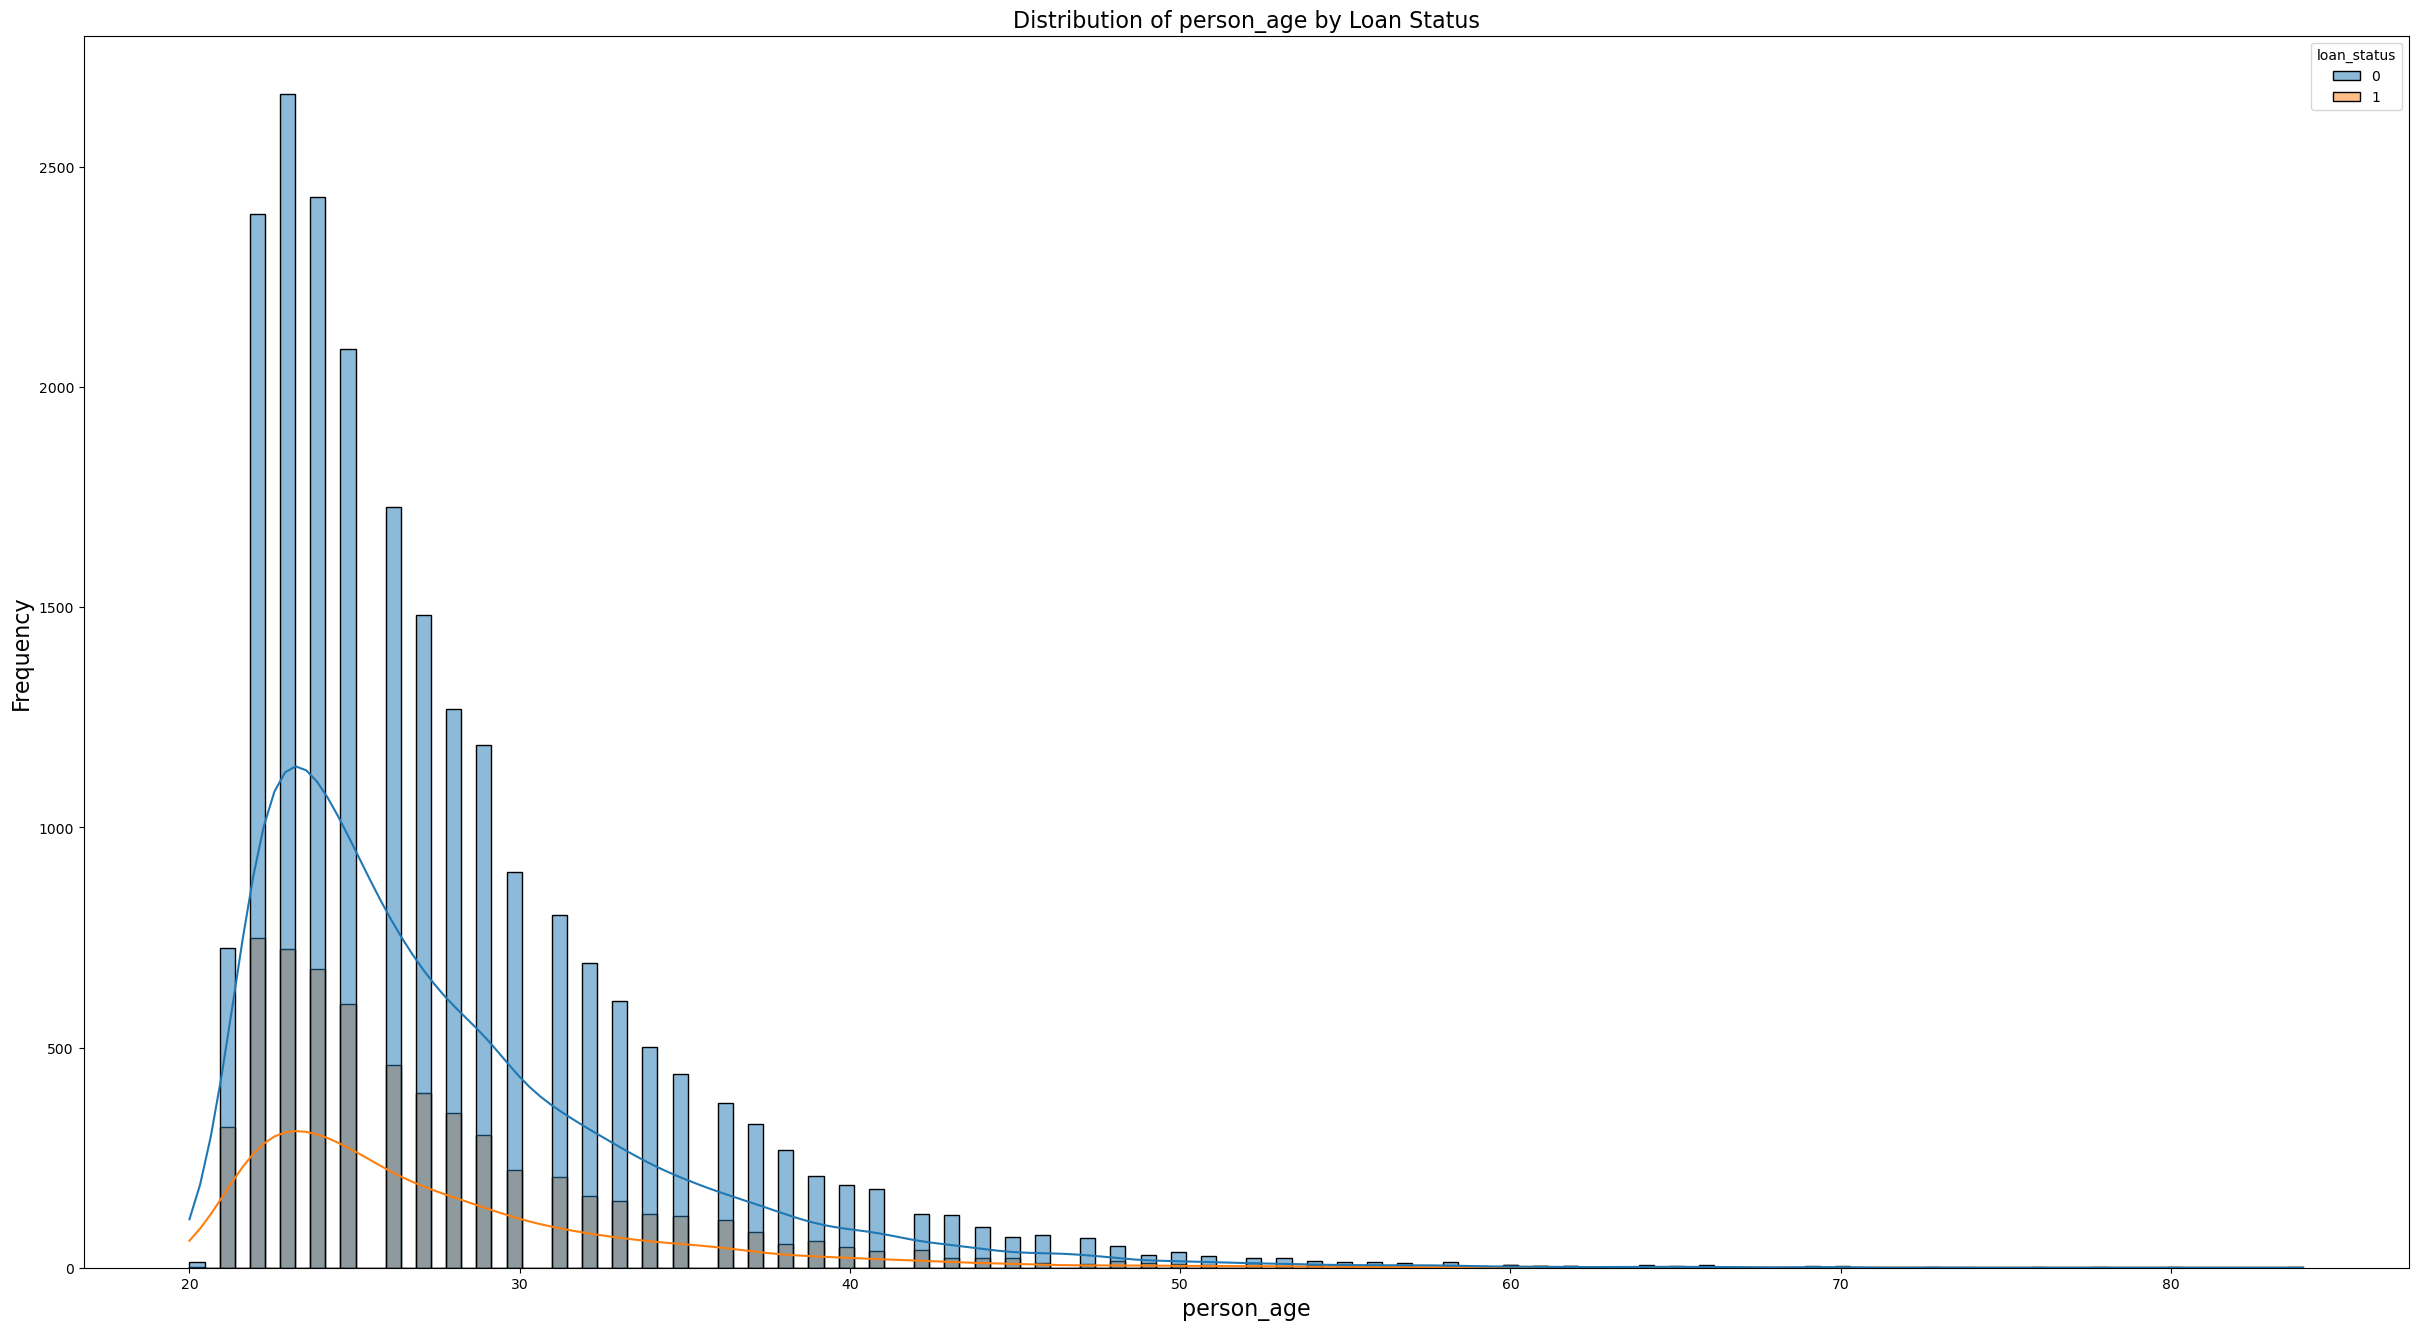

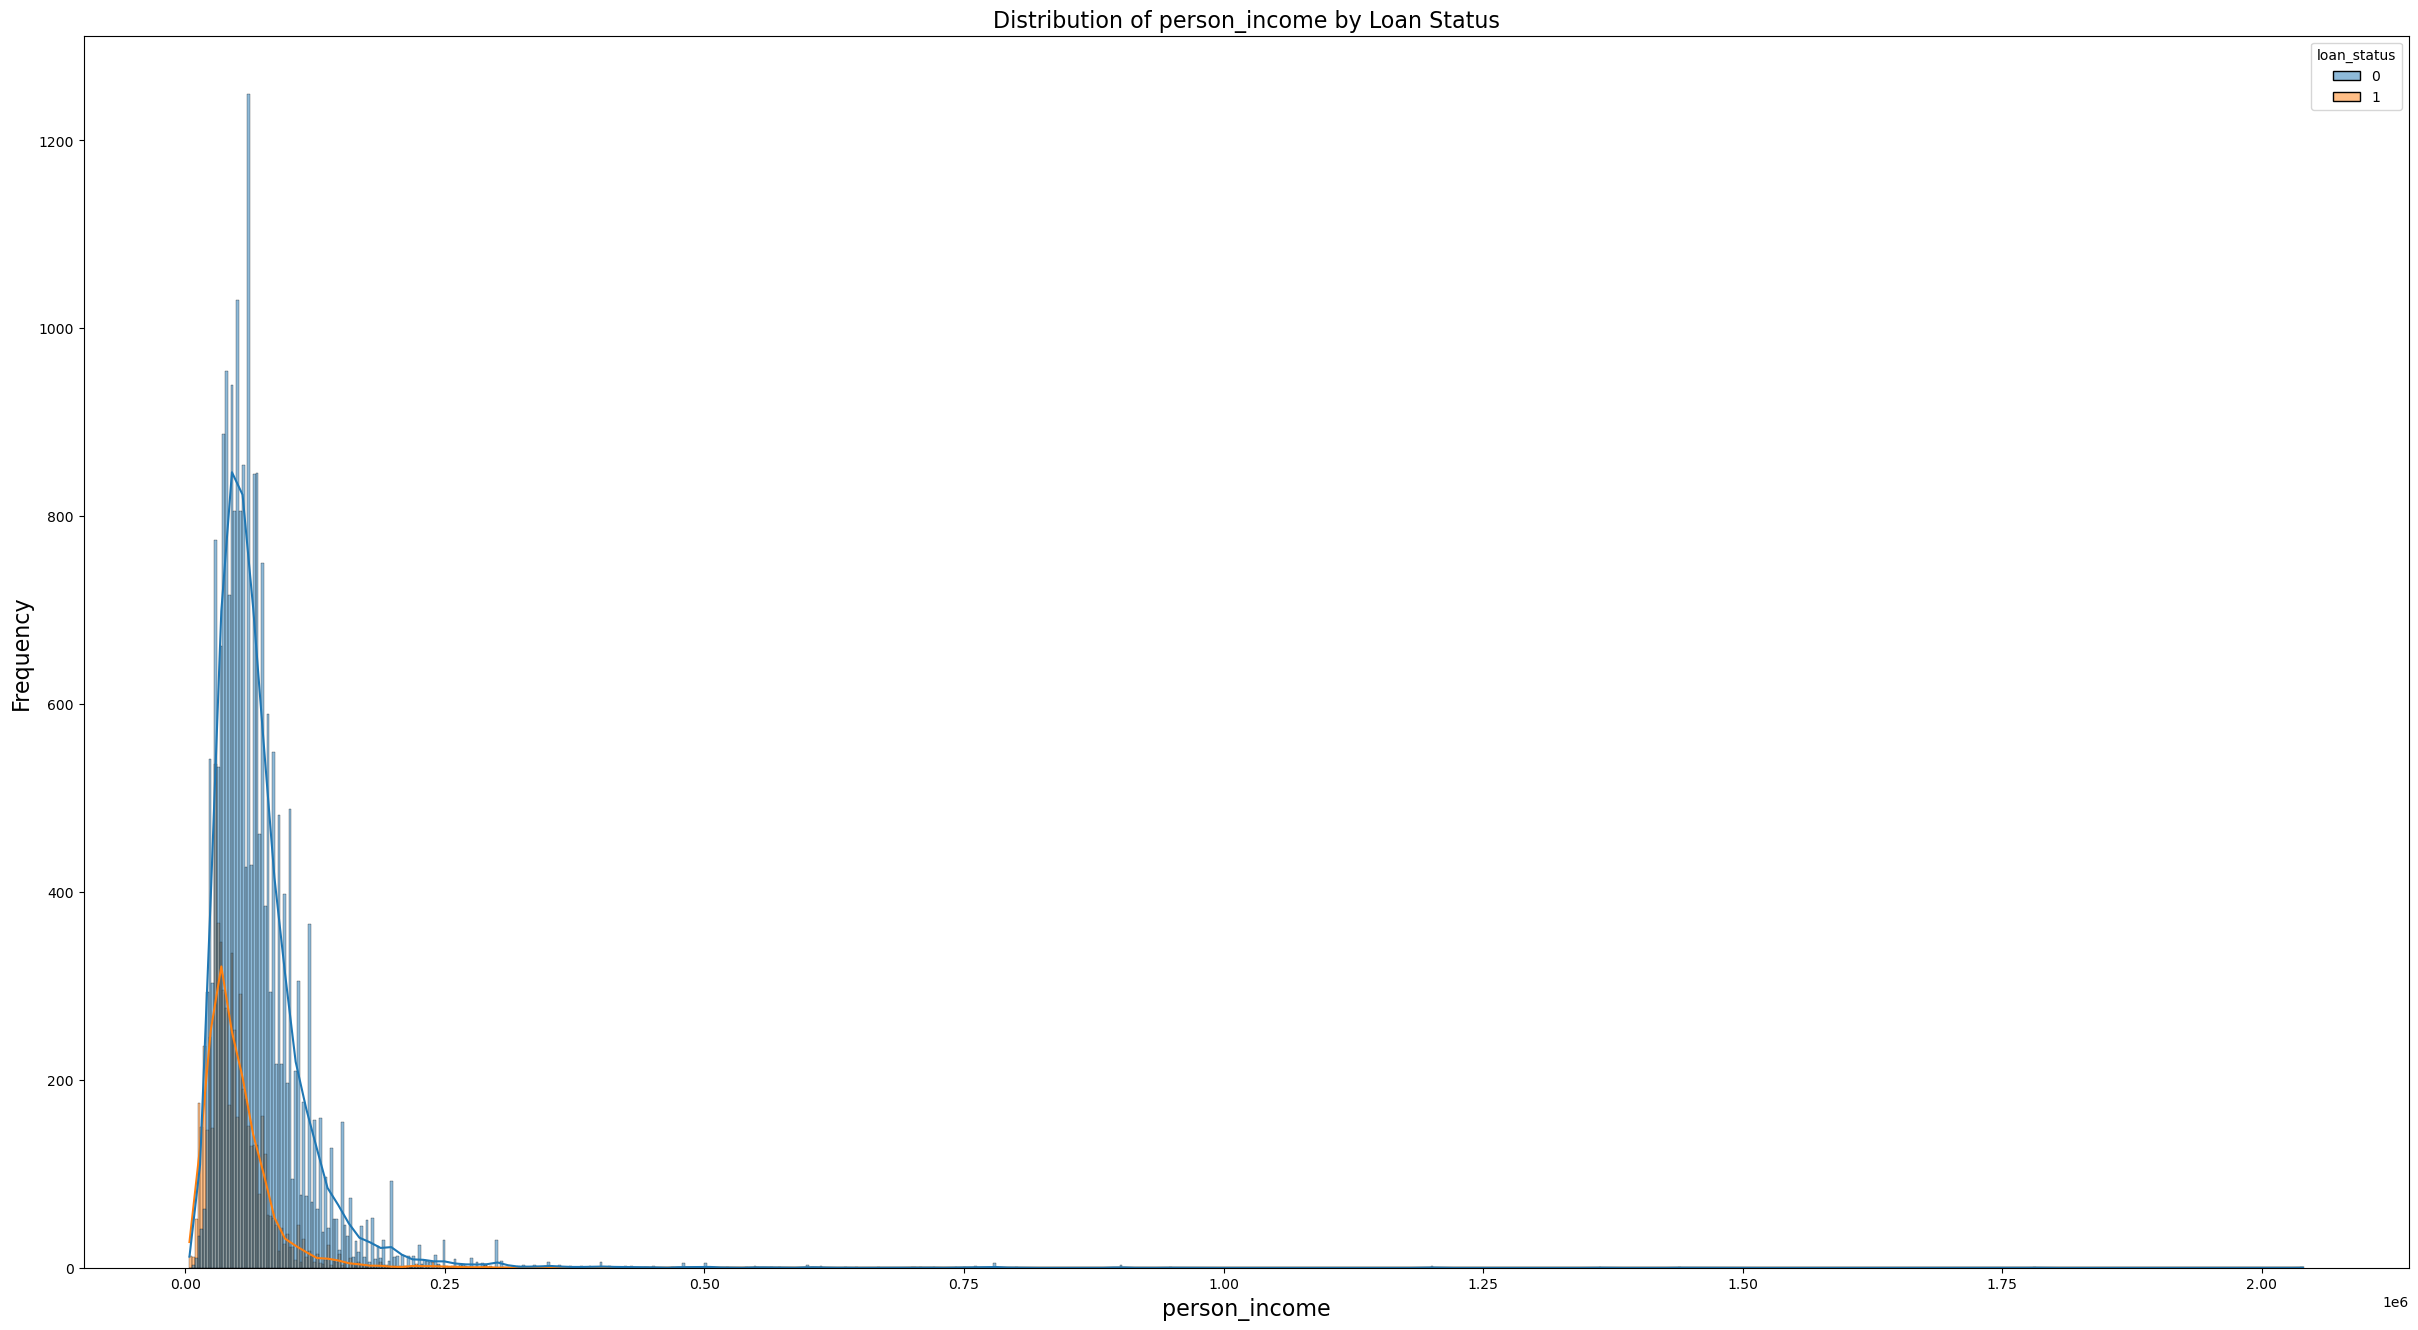

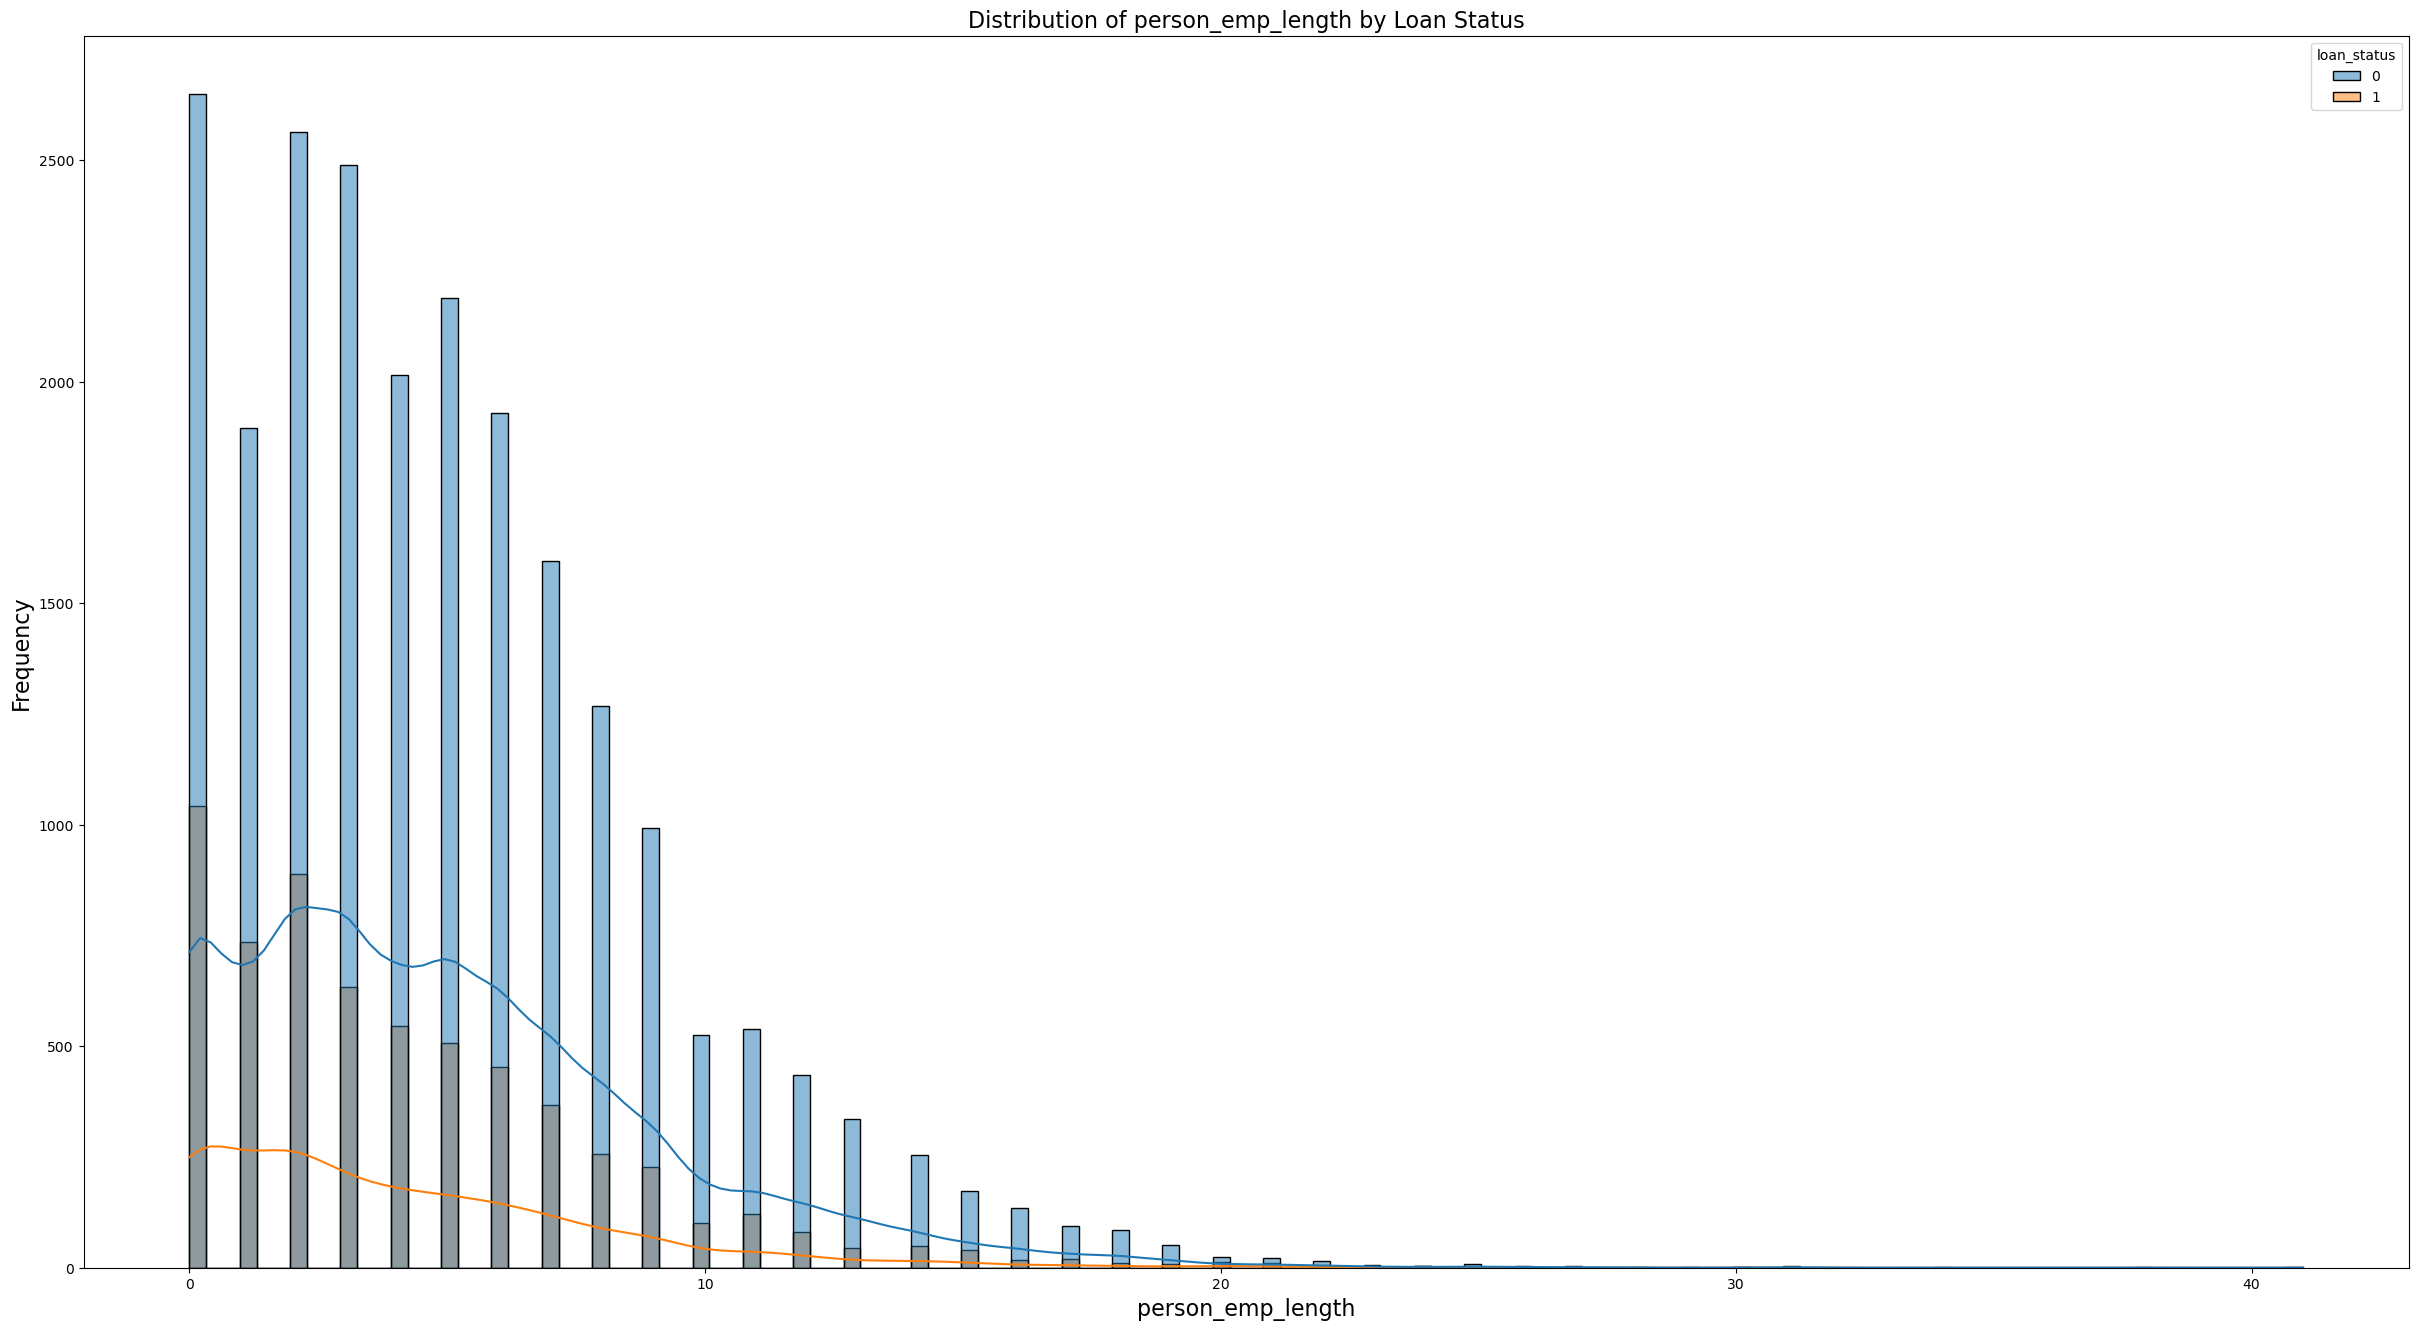

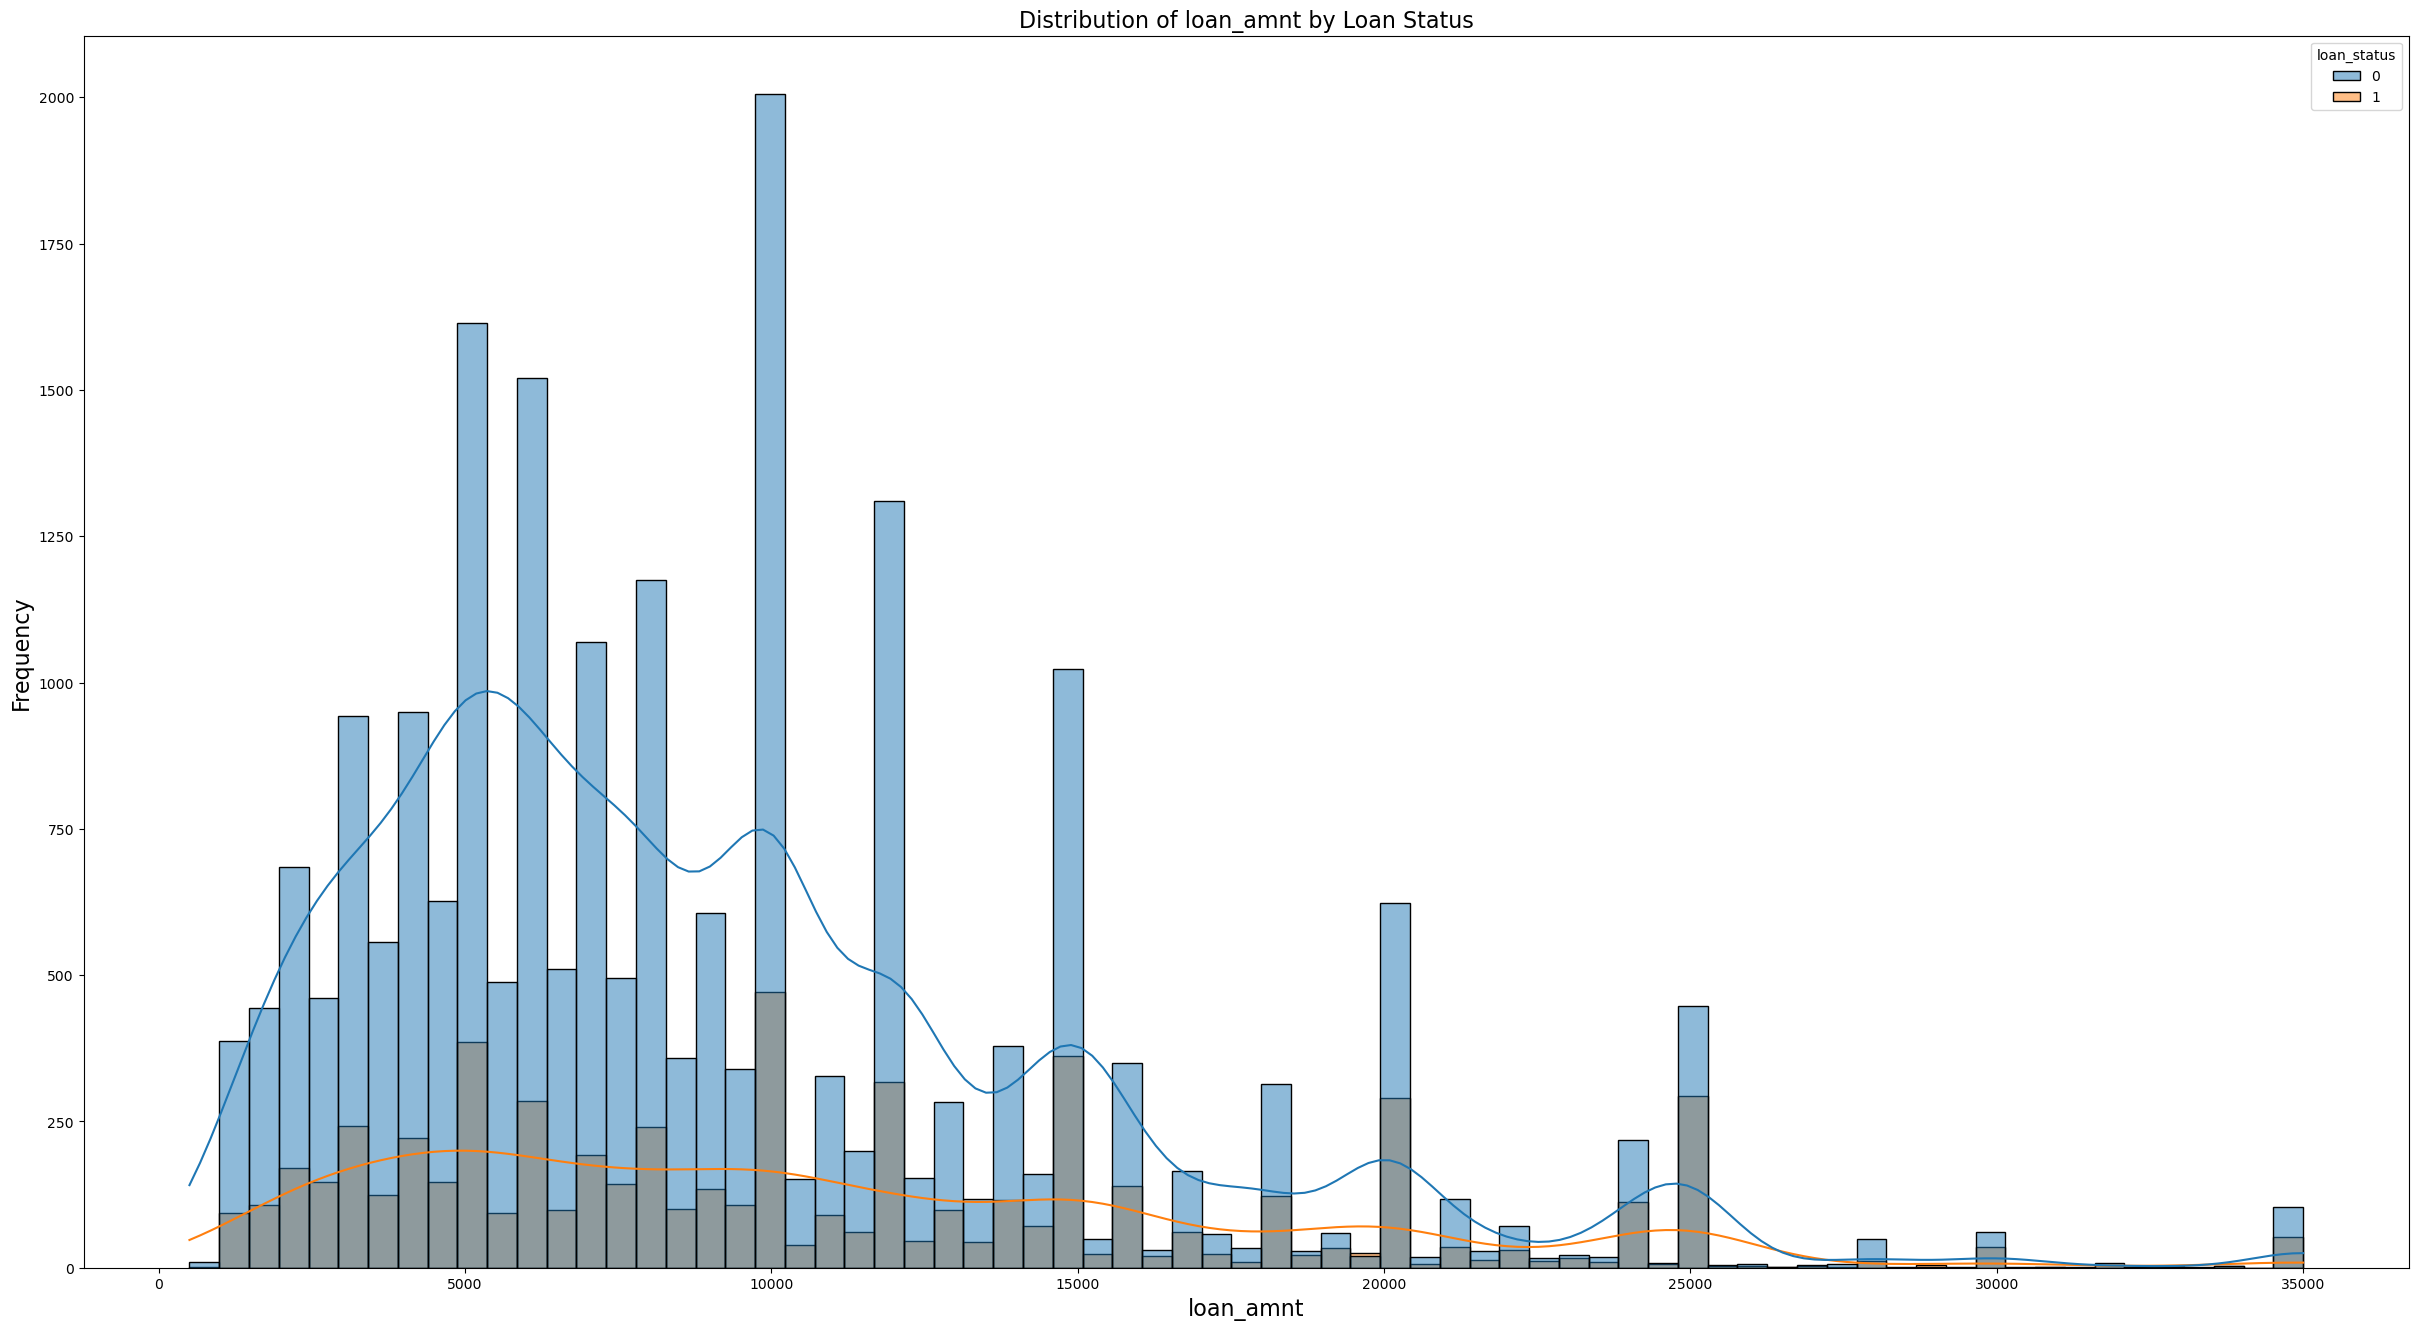

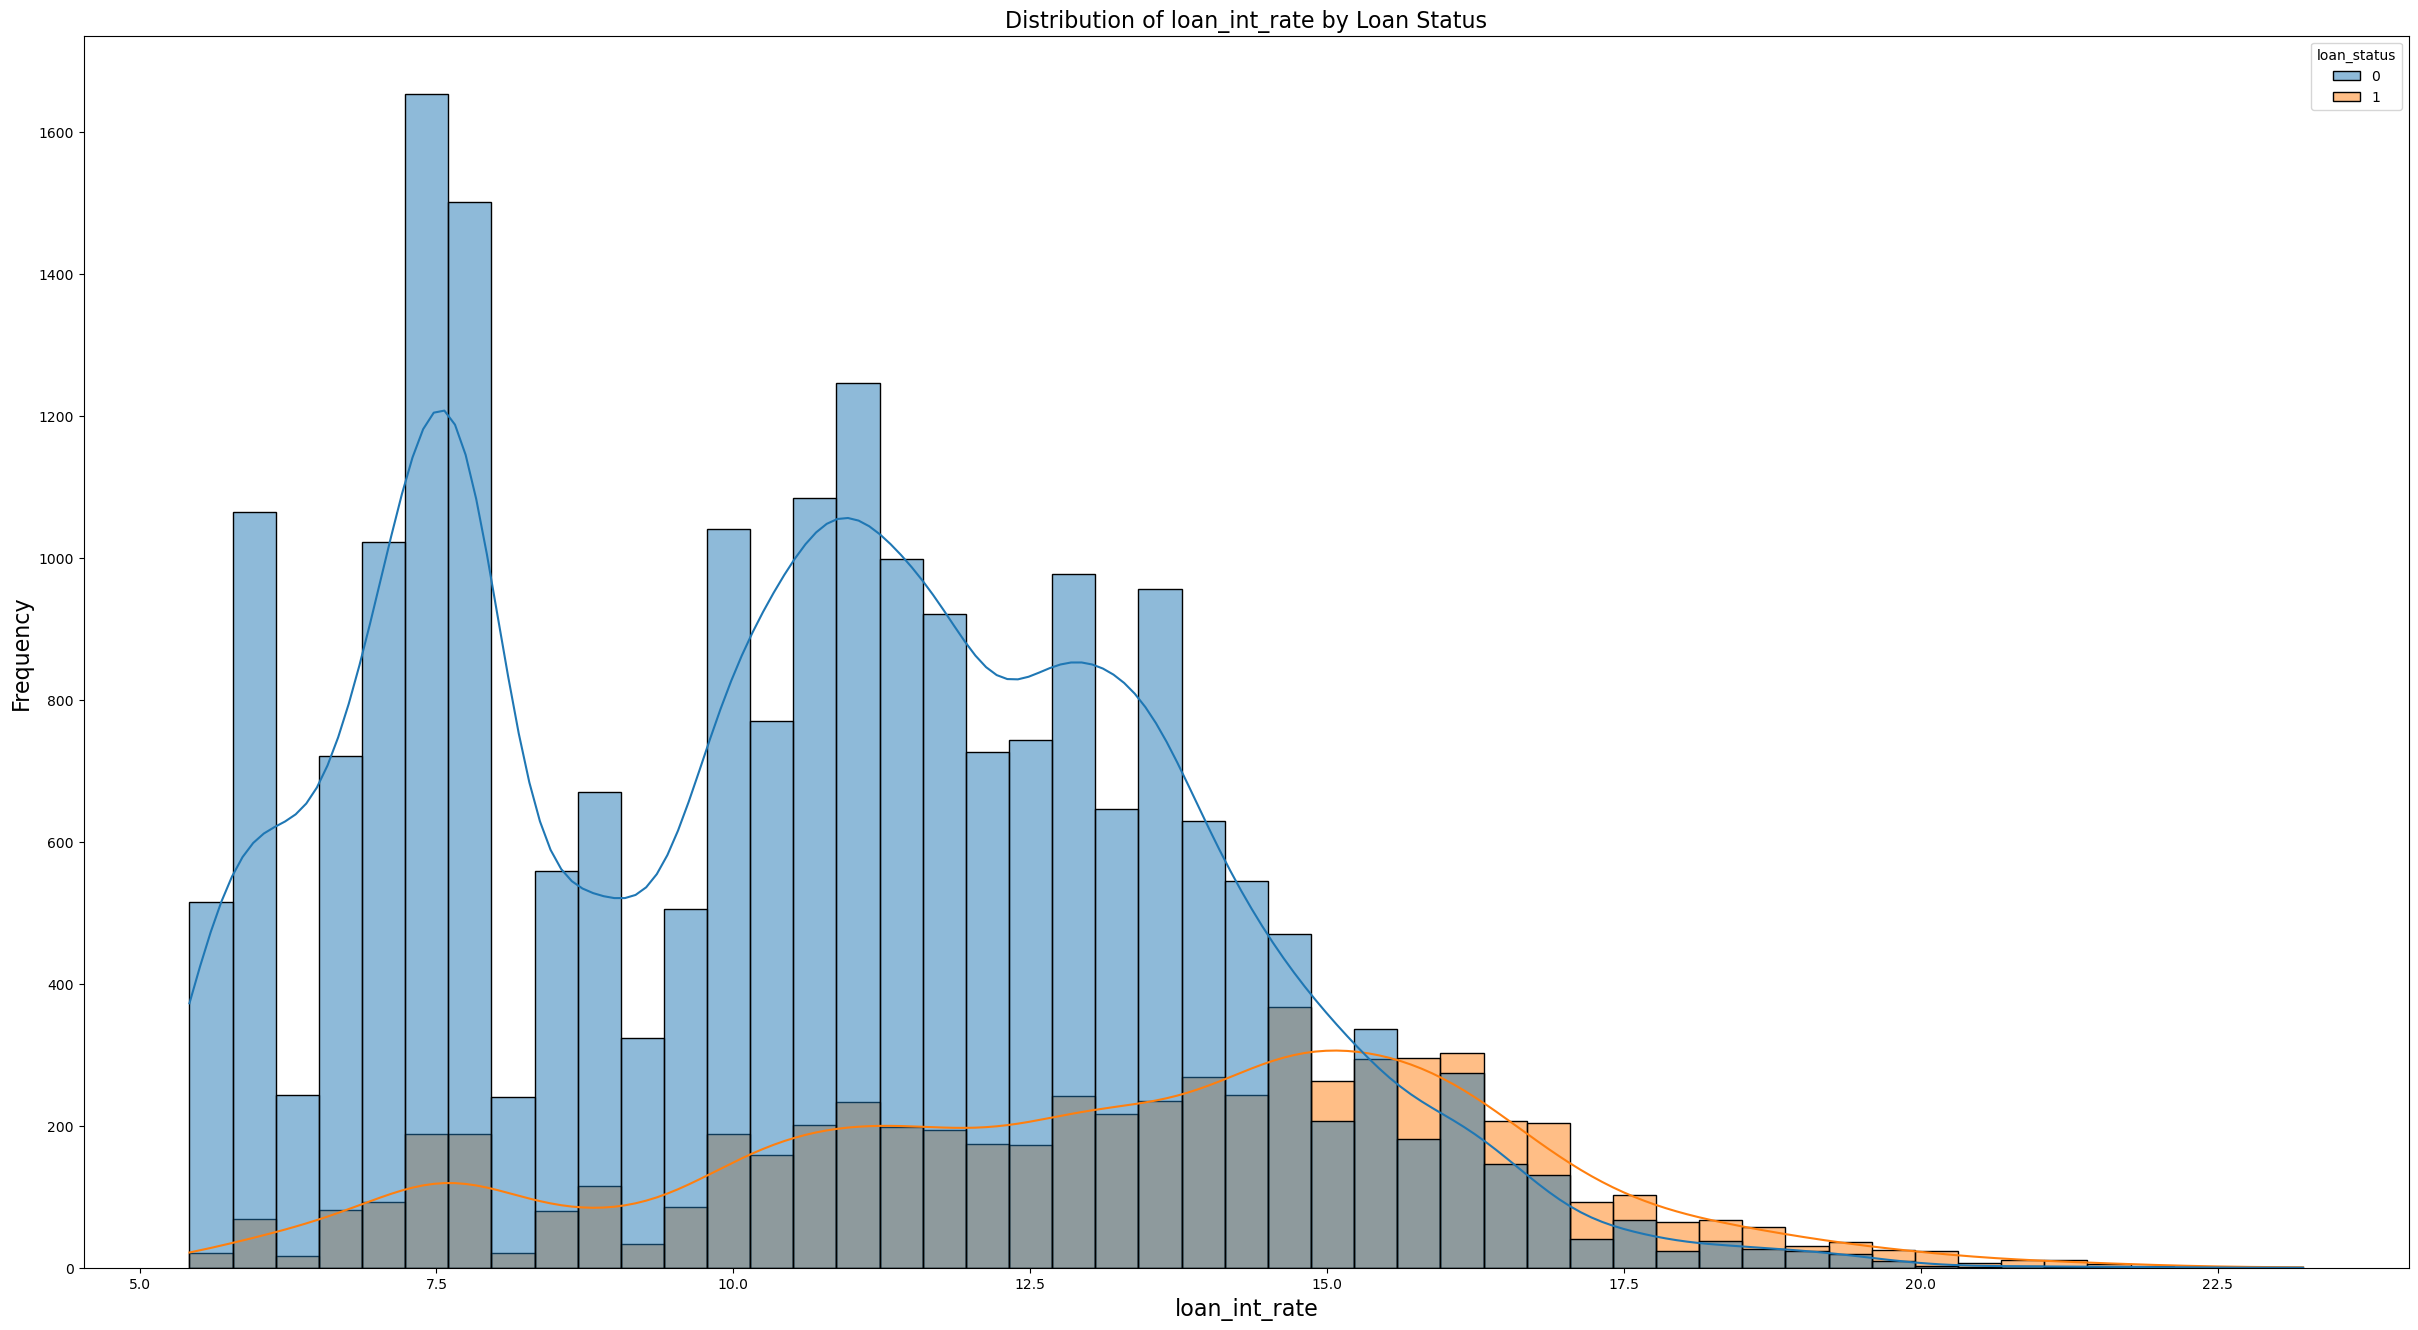

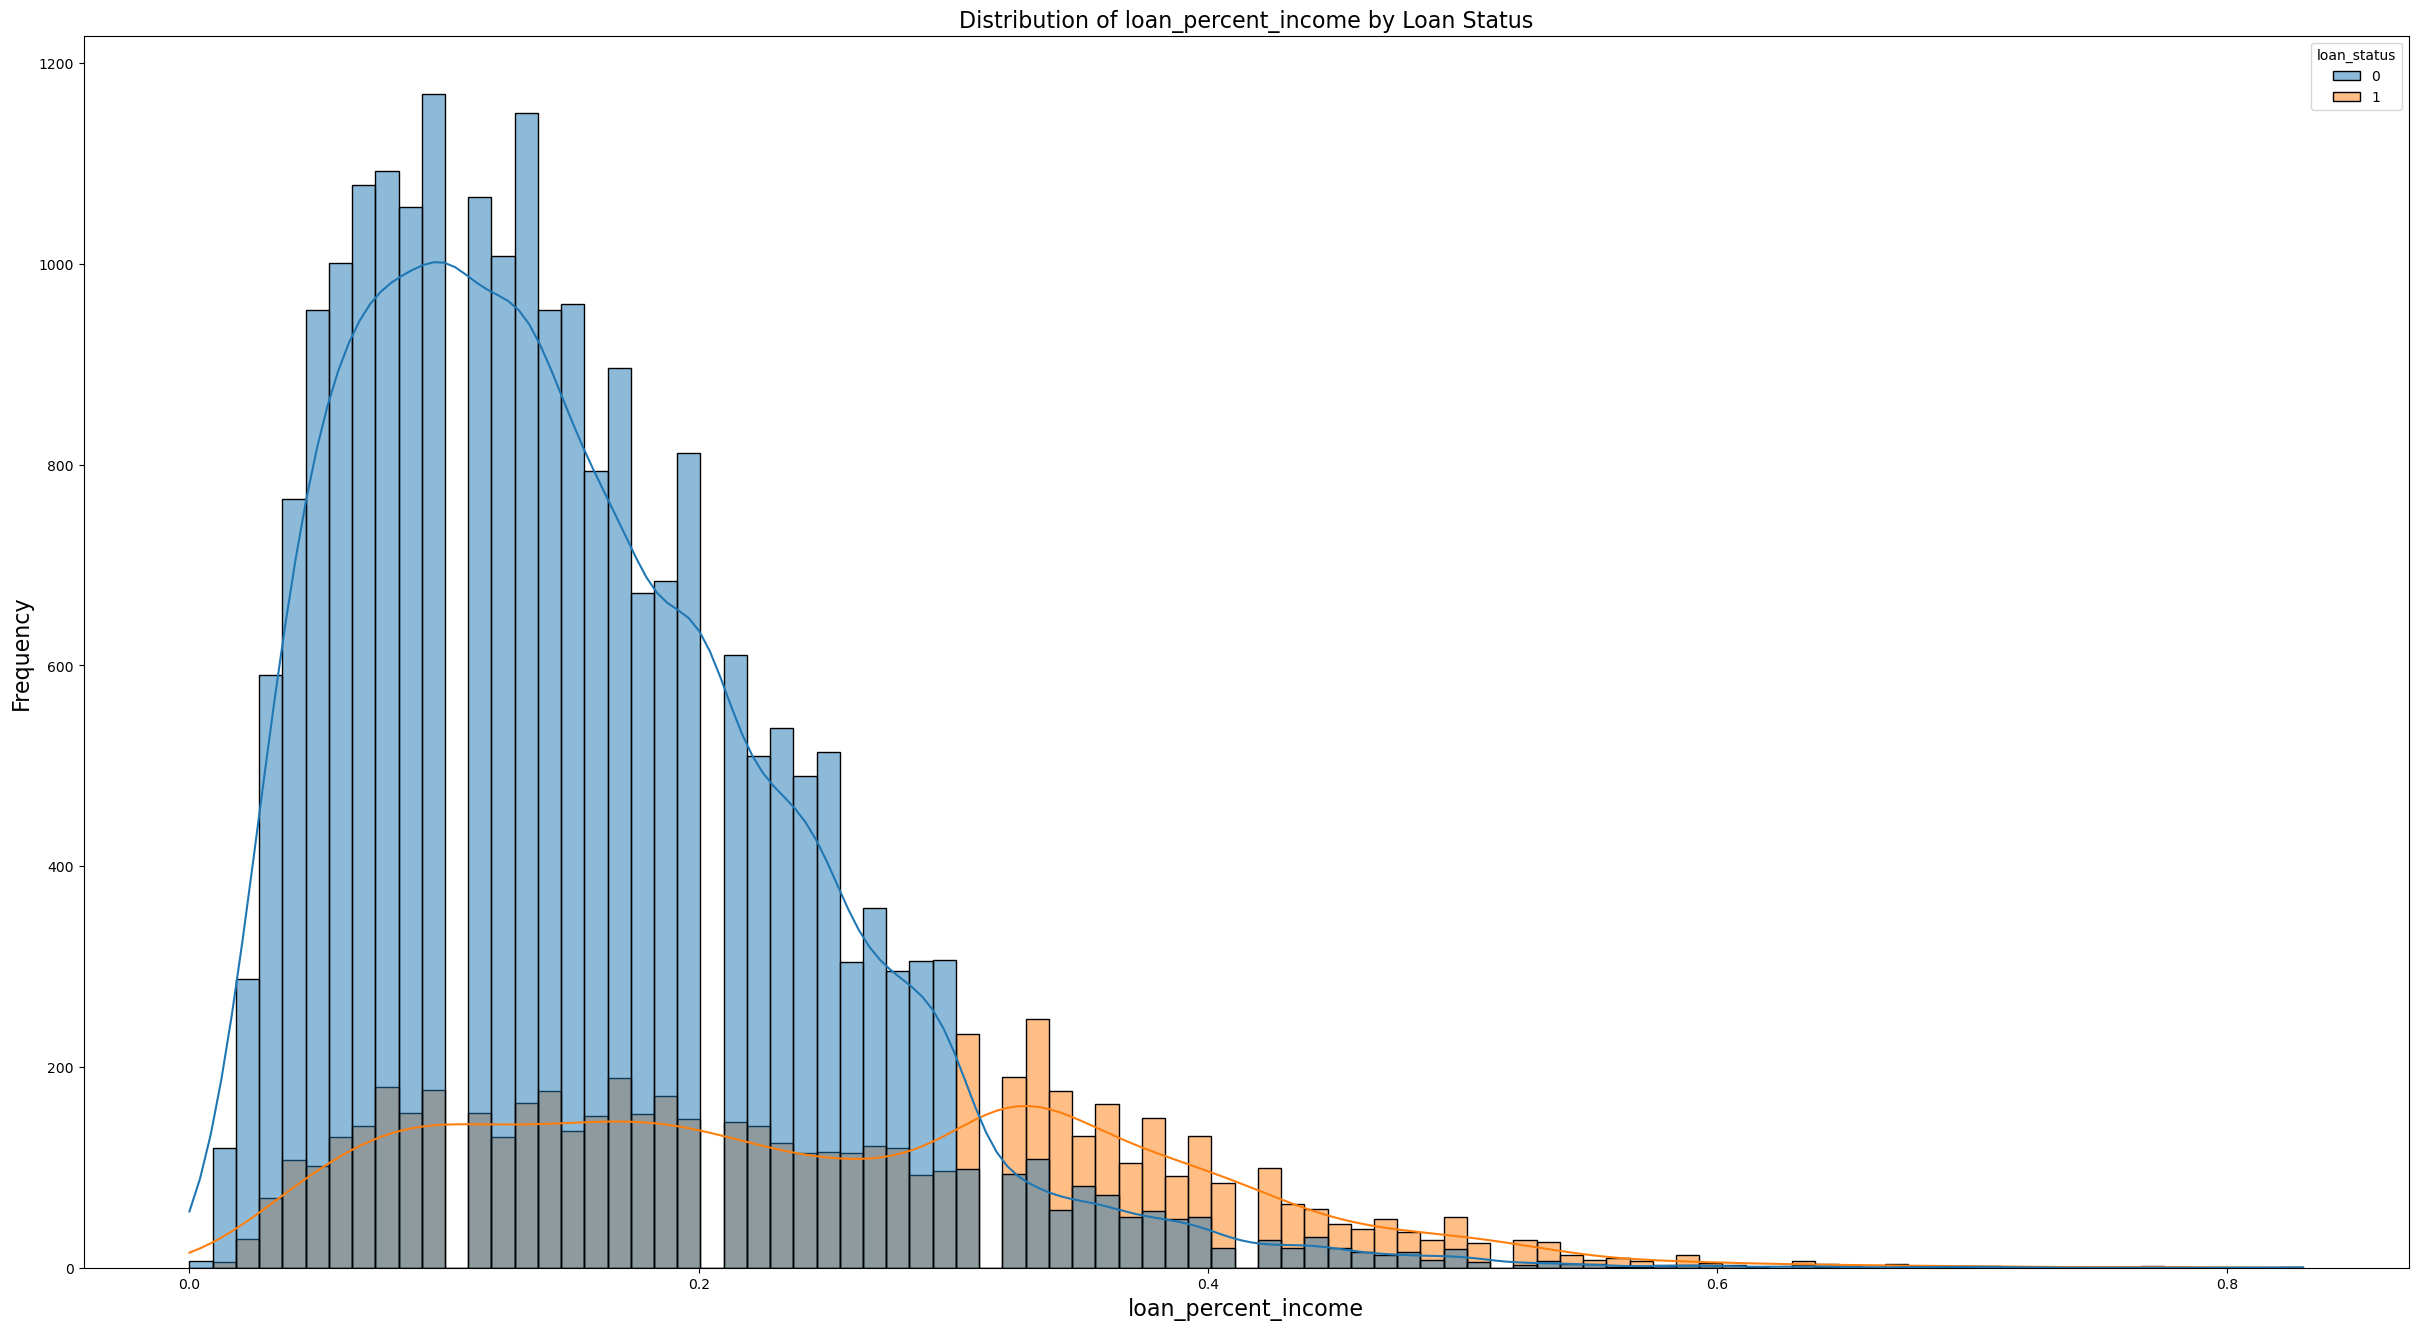

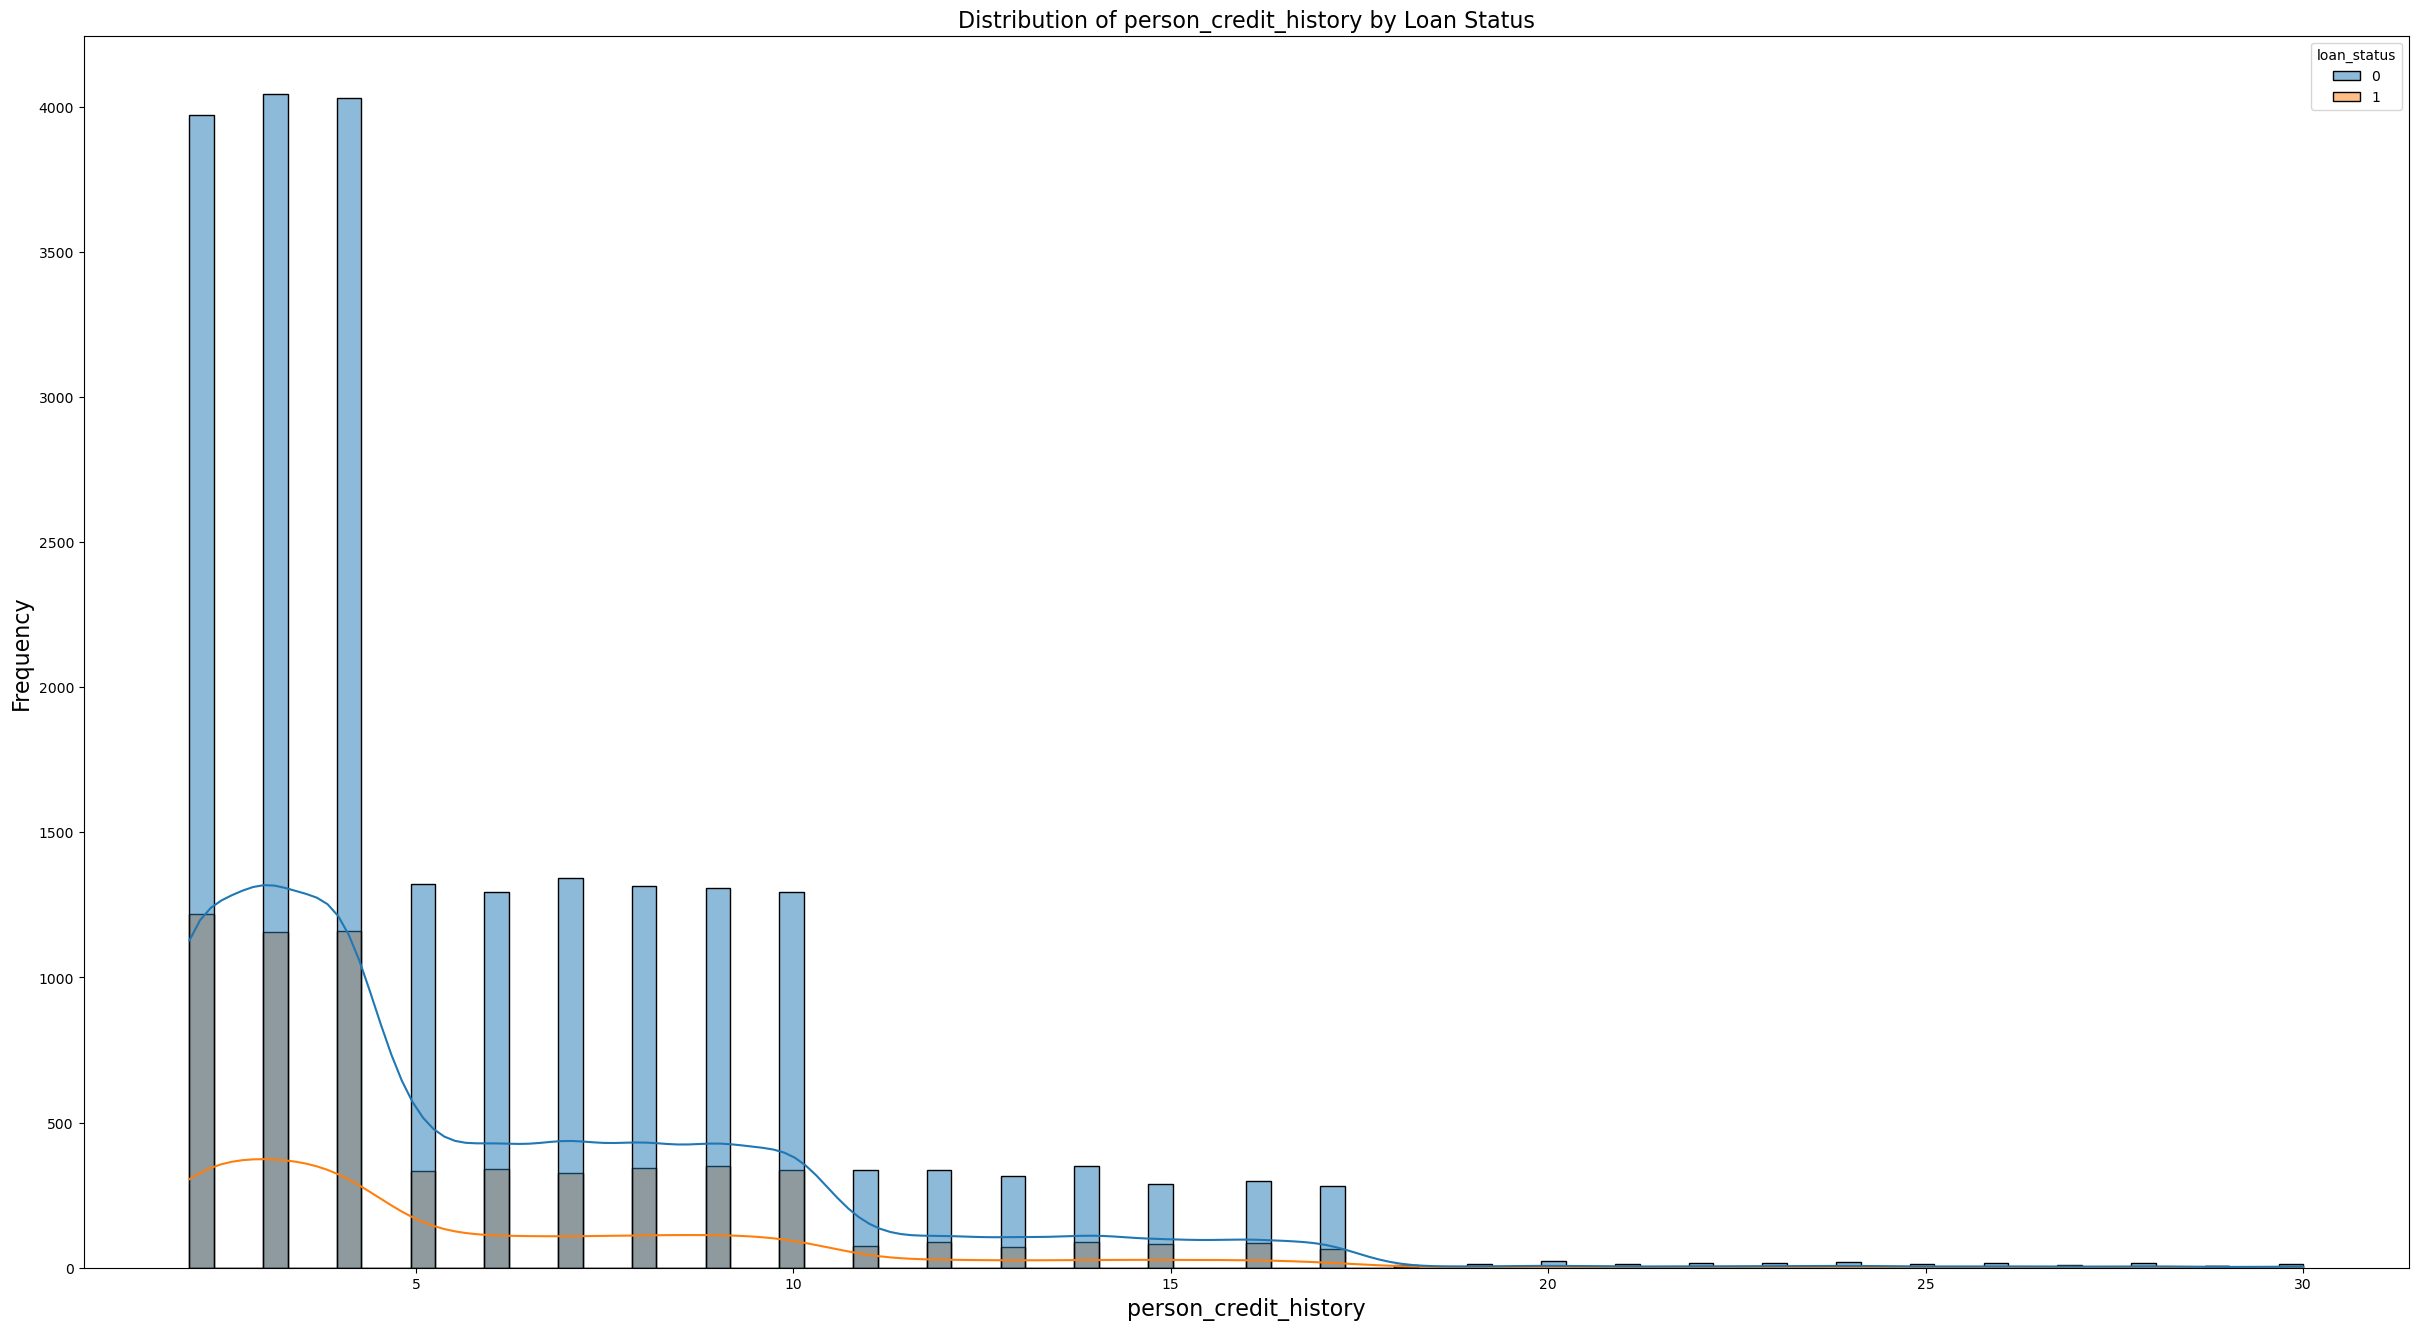

In [4]:
for feature in numeric_features:
    plt.figure(figsize=(30, 16))
    sns.histplot(data=df, x=feature, hue='loan_status', kde=True)
    plt.title(f'Distribution of {feature} by Loan Status', fontsize=16)
    plt.xlabel(feature, fontsize=16)
    plt.ylabel('Frequency', fontsize=16)
    plt.show()



## Analysis of Loan Status Across Categorical Features

The count plots illustrating loan status across categorical features reveal notable insights into their impact on loan default probability. Among these features, loan grade stands out prominently, displaying distinct variations in default rates across different grade categories. Specifically, higher loan grades exhibit lower default frequencies, indicating a strong negative correlation between grade and default probability. Conversely, while other categorical features such as home ownership type and loan intent also demonstrate varying default rates, their impact appears comparatively less pronounced than that of loan grade. This observation underscores the significance of including loan grade as a critical predictor in our model, suggesting it plays a pivotal role in predicting and understanding loan default behavior.


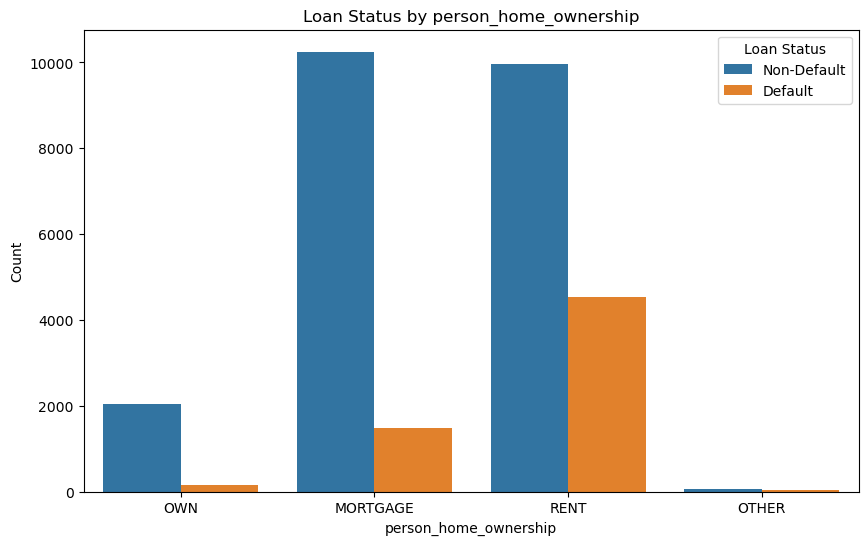

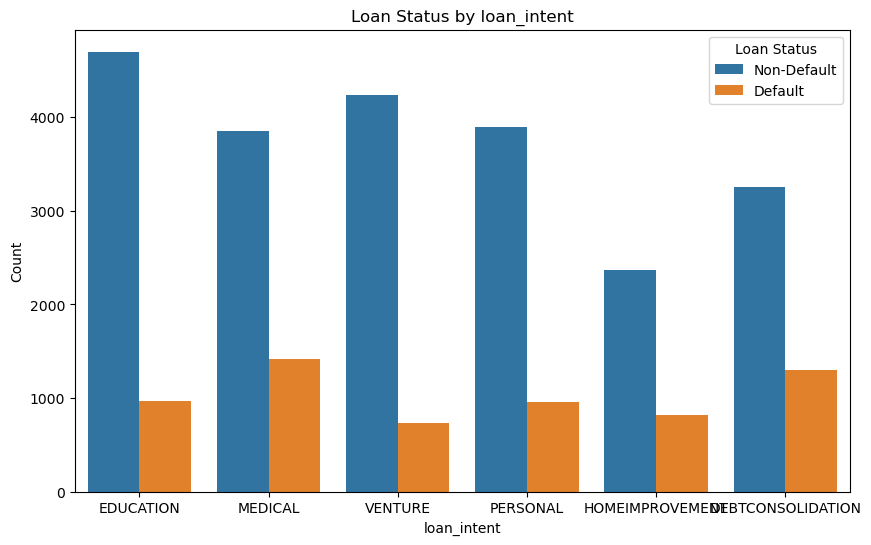

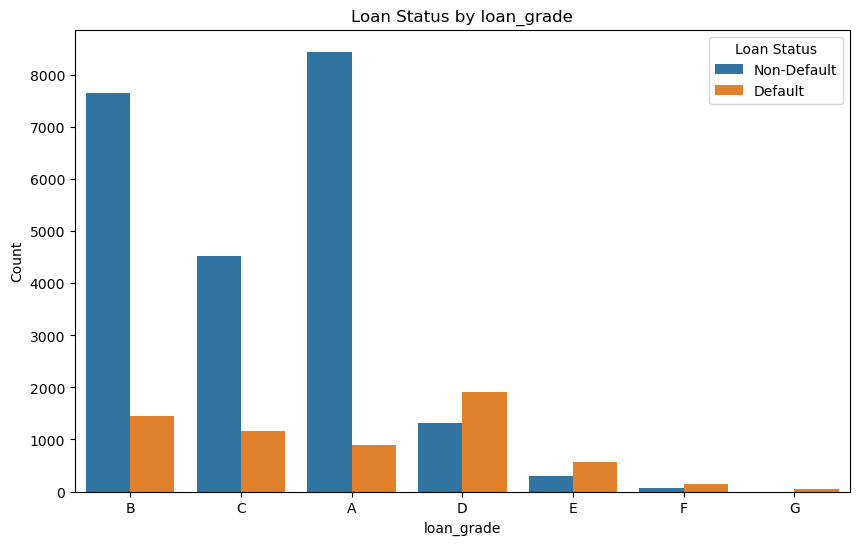

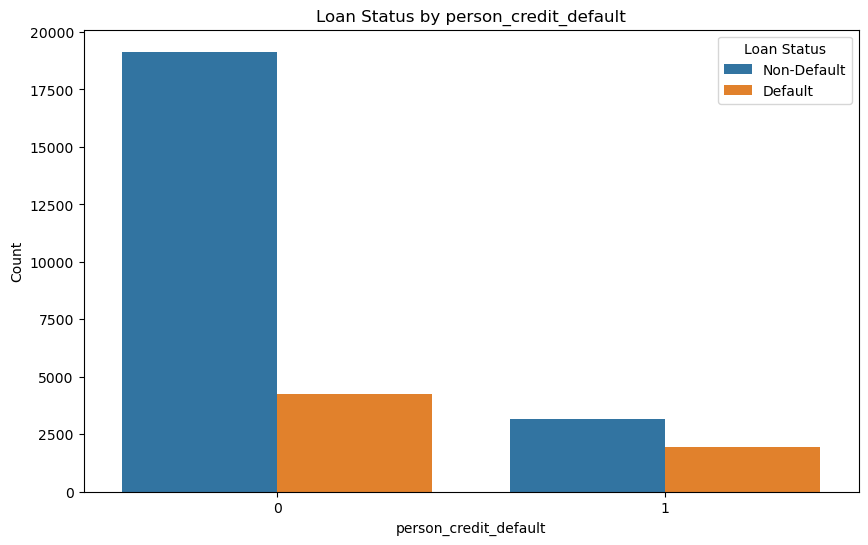

In [5]:


for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=feature, hue='loan_status', data=df)
    plt.title(f'Loan Status by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend(title='Loan Status', labels=['Non-Default', 'Default'])
    plt.show()

 

### Initial Logistic Regression Modeling and Data Preparation Phase

During the initial model fitting, a warning was encountered due to reaching the maximum number of iterations, highlighting the necessity of scaling the data for improved convergence and model performance. 

Categorical variables ('person_home_ownership', 'loan_intent', 'loan_grade') were encoded using one-hot encoding to facilitate their inclusion in the logistic regression model. This transformation expanded each categorical variable into binary columns, excluding the first category to prevent redundancy. 

Subsequently, the dataset was split into training and testing sets, with the logistic regression model trained on the training data. The model's performance on predicting loan status was evaluated using precision, recall, and F1-score metrics via the classification report generated for the test set.


In [18]:


# Encode categorical variables using one-hot encoding
df_encoded = pd.get_dummies(df, columns=['person_home_ownership', 'loan_intent', 'loan_grade'], drop_first=True)
# Print out the column names to verify encoding
print("Columns after one-hot encoding:")
print(df_encoded.columns)
# Prepare X and y for modeling
X = df_encoded.drop('loan_status', axis=1) 
y = df_encoded['loan_status']  
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)
# Initialize and fit the logistic regression model
model = LogisticRegression(class_weight='balanced',random_state=33)
model.fit(X_train, y_train)
# Predict on the test set
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


Columns after one-hot encoding:
Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'person_credit_default', 'person_credit_history',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_grade_B',
       'loan_grade_C', 'loan_grade_D', 'loan_grade_E', 'loan_grade_F',
       'loan_grade_G'],
      dtype='object')
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      4444
           1       0.42      0.76      0.54      1255

    accuracy                           0.72      5699
   macro avg       0.67      0.73      0.67      5699
weighted avg       0.80      0.72      0.74      5699



c:\Users\Jimmy\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Scaling Numerical Features and Generating Summary Report for Logistic Regression Model

Initially, there were convergence issues due to numerical features not being scaled. This issue was addressed by scaling these features. Subsequently, the model successfully converged and yielded meaningful results:

- **Model Fit**: The logistic regression model achieved convergence with a log-likelihood of -9565.8 and a pseudo R-squared value of 0.3584. While the pseudo R-squared suggests the model explains approximately 35.84% of the variance in loan status, which may seem low, it's important to note that logistic regression does not directly interpret variance in the same way as linear regression. Instead, the log-likelihood provides a measure of how well the model predicts loan default outcomes.
  
- **Significant Predictors**: Several predictors showed statistically significant effects on loan status. Variables like loan_percent_income, loan_int_rate, and higher loan grades (loan_grade) demonstrated positive coefficients, indicating that higher values of these predictors increase the likelihood of loan default. Categorical variables, such as person_home_ownership and loan_intent, also plays significant roles. 

- **Insignificant Predictors**: person_age (p-value = 0.084), person_credit_history (p-value = 0.387), loan_intent_HOMEIMPROVEMENT (p-value = 0.500), loan_grade_B (p-value = 0.190), and loan_grade_C (p-value = 0.057) are identified as the least significant predictors. These higher p-values suggest that these variables may not significantly contribute to predicting whether a loan will default or not, based on the current model and dataset.

- **Model Evaluation**: The model's robustness was assessed using statistical metrics and significance tests. The LLR (Log-Likelihood Ratio) test yielded a p-value of 0.000, indicating that the model significantly improves upon a baseline model with no predictors. This reinforces the model's predictive power by rejecting the null hypothesis that there is no relationship between the predictors and the likelihood of loan default.

In summary, scaling numerical features resolved convergence issues and facilitated a comprehensive analysis of predictors influencing loan status. The model provided insights into both numerical and categorical variables, highlighting significant predictors and their respective impacts on loan approval probabilities.



In [16]:

# Scale the independant variables
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convert scaled array back to DataFrame 
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index) 
# print(X_scaled.head())
y = y.loc[X_scaled.index]

# Display statsmodels logistic regression on entire dataset to get a summary of 
X_scaled_sm = sm.add_constant(X_scaled)
model_sm = sm.Logit(y, X_scaled_sm)
result = model_sm.fit()
print(result.summary())



Optimization terminated successfully.
         Current function value: 0.335702
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:                28495
Model:                          Logit   Df Residuals:                    28472
Method:                           MLE   Df Model:                           22
Date:                Fri, 28 Jun 2024   Pseudo R-squ.:                  0.3584
Time:                        11:29:36   Log-Likelihood:                -9565.8
converged:                       True   LL-Null:                       -14910.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -3.9821      0.094    -42.420      0.000   

### Assessment of Variance Inflation Factor (VIF) 

- **'person_age'**: High VIF (56.911) suggests strong multicollinearity with other predictors, indicating that age might be closely correlated with other variables in the dataset.

- **'loan_int_rate'**: Very high VIF (70.741) indicates severe multicollinearity issues with other predictors, suggesting that loan_int_rate is strongly correlated with multiple variables in the dataset.


- Categorical variables such as **'person_credit_history'**, **'person_home_ownership'**, **'loan_intent'**, and **'loan_grade'** show varying levels of collinearity, with VIF values generally indicating acceptable levels of multicollinearity.

Overall, elevated VIF values for 'person_age' and 'loan_int_rate' indicate potential issues with multicollinearity that may affect the accuracy and interpretability of regression coefficients. Addressing multicollinearity through techniques such as feature selection or regularization could improve the reliability of the regression model. Notably, the high VIF observed for 'loan_int_rate' is likely due to its correlation with loan grades, which determine interest rates. This correlation suggests that including both variables in the model may lead to instability or redundancy in coefficient estimates.


In [17]:

# check multicollinearity among the predictors
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


                        feature        VIF
0                    person_age  56.911308
1                 person_income   4.880622
2             person_emp_length   2.661828
3                     loan_amnt   8.848534
4                 loan_int_rate  70.741361
5           loan_percent_income   8.844967
6         person_credit_default   2.026621
7         person_credit_history  10.004591
8   person_home_ownership_OTHER   1.010612
9     person_home_ownership_OWN   1.238510
10   person_home_ownership_RENT   2.602304
11        loan_intent_EDUCATION   2.171802
12  loan_intent_HOMEIMPROVEMENT   1.695392
13          loan_intent_MEDICAL   2.115237
14         loan_intent_PERSONAL   2.026210
15          loan_intent_VENTURE   2.064332
16                 loan_grade_B   4.627577
17                 loan_grade_C   6.555951
18                 loan_grade_D   5.831955
19                 loan_grade_E   2.763247
20                 loan_grade_F   1.557302
21                 loan_grade_G   1.206850


### Identifying Multicollinearity
Based on the analysis below of the correlation matrix, it is confirmed that **'loan_int_rate'** is highly correlated with **'loan_grade'**, which explains the very high VIF (70.741) observed for **'loan_int_rate'**. This indicates that **'loan_int_rate'** shares a strong relationship with **'loan_grade'** and potentially other variables. Similarly, **'person_age'** exhibits a high VIF (56.911), which can be attributed to its strong correlation with **'person_credit_history'**. These findings from the correlation matrix reinforce the multicollinearity issues identified through the VIF analysis, highlighting the close relationships between these specific pairs of features in the dataset.

In this scenario, it suggests that either **'loan_int_rate'** or **'loan_grade'**, as well as **'person_age'** or **'person_credit_history'**, could be removed from the model without significantly impacting its performance. This understanding is crucial for simplifying the model and reducing redundancy in feature representation.



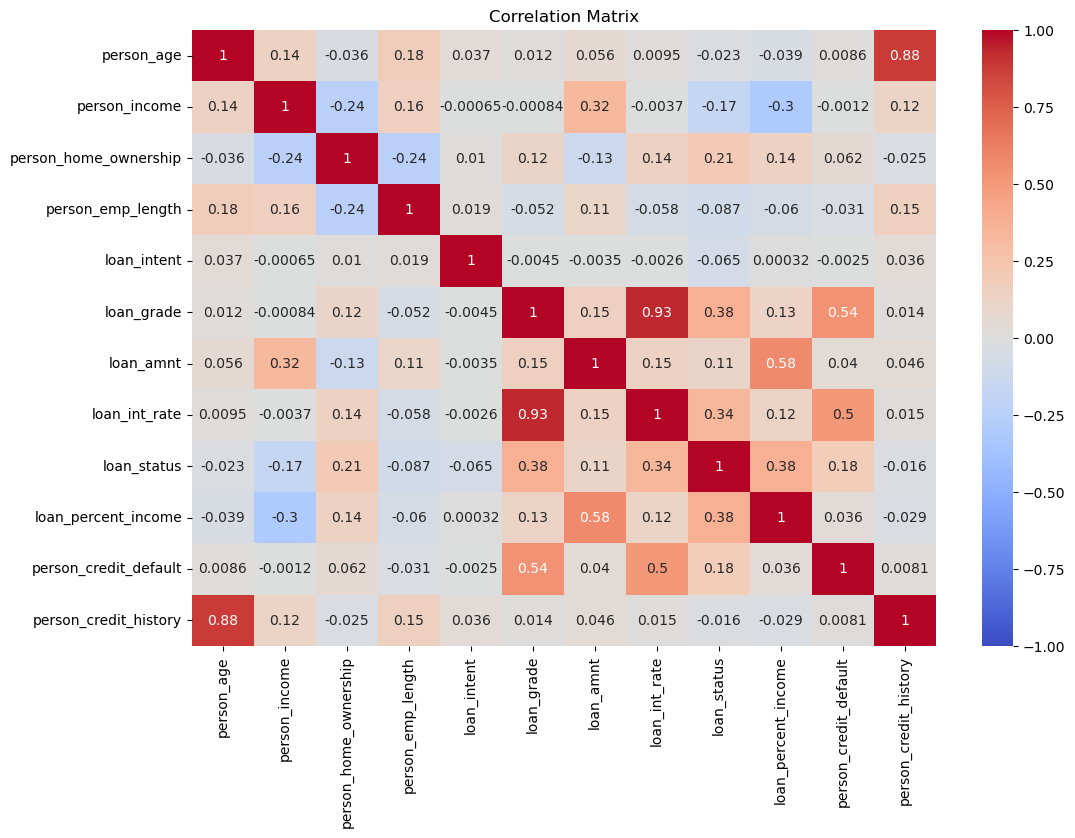

In [9]:
# Correlation Matrix
label_encoder = LabelEncoder()
df['person_home_ownership'] = label_encoder.fit_transform(df['person_home_ownership'])
df['loan_intent'] = label_encoder.fit_transform(df['loan_intent'])
df['loan_grade'] = label_encoder.fit_transform(df['loan_grade'])
plt.figure(figsize=(12, 8))
numeric_data = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


## Analyzing Class Imbalance in the Dataset

To understand the distribution of loan defaults (denoted by 1) and non-defaults (denoted by 0) in our dataset, we performed a count of the rows corresponding to each category. This analysis helps to identify any imbalance in the classes, which is crucial for selecting appropriate machine learning techniques and performance metrics.

### From the count and visualization, we observe the following:

the counts of instances for each class (non-default: 20,000 and default: 4,000), while the accompanying pie chart with percentages (non-default: 78%, default: 23%) emphasizes the relative distribution, effectively highlighting the significant class imbalance in the dataset.


### Importance of Addressing Class Imbalance

Class imbalance significantly affects machine learning model performance. Models trained on imbalanced data often exhibit bias towards the majority class, resulting in suboptimal performance on the minority class. To address this issue, several techniques can be employed:

- **Resampling**: Adjusting the class distribution through oversampling (increasing the minority class) or undersampling (decreasing the majority class).

- **Specialized Algorithms**: Employing algorithms like SMOTE (Synthetic Minority Over-sampling Technique) or ensemble methods designed to handle imbalanced datasets effectively.

- **weighted balancing**: Introducing a weighted balancing parameter adjusts for the class imbalance, allowing the model to give proportionately more importance to minority class instances during training, thereby aiming to improve overall predictive performance. 

Having observed the imbalance, for the purpose of illustrating its effects on the results, we opted to employ a weighted approach in this part of the project, with the results noted in the next section.




0    22308
1     6187
Name: loan_status, dtype: int64


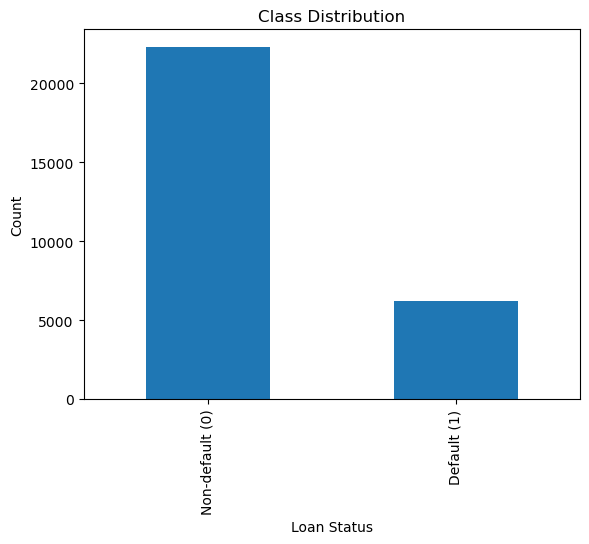

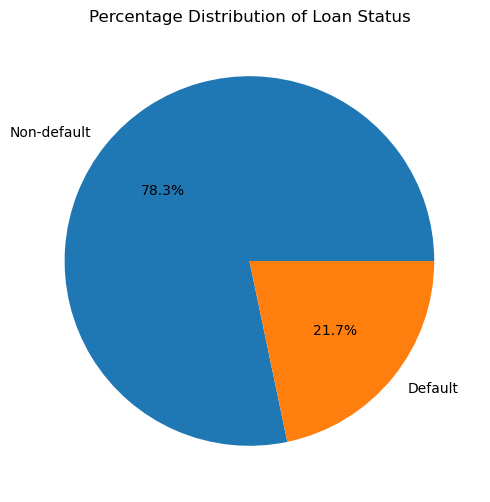

In [26]:
# Count the number of instances for each case (default vs. nondefault)
class_counts = df['loan_status'].value_counts()
print(class_counts)
# Bar Chart
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-default (0)', 'Default (1)'])
plt.show()

#Total number of observations (rows) in the DataFrame
total_count = df.shape[0]

# Counting default and non-default cases
default_count = df[df['loan_status'] == 1].shape[0]
non_default_count = df[df['loan_status'] == 0].shape[0]
# Calculate percentages
non_default_percentage = (non_default_count / total_count) * 100
default_percentage = (default_count / total_count) * 100

# Data to plot
labels = ['Non-default', 'Default']
sizes = [non_default_percentage, default_percentage]

# Plotting the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Percentage Distribution of Loan Status')
plt.show()

# Logistic Regression Modeling

## Comparing Unbalanced Model vs. Balanced Model using weighted balancing approach

The unbalanced model shows an overall accuracy of 87%. It achieves a precision of 0.77 and recall of 0.55 for default cases, with an F1-score of 0.64.

In contrast, the balanced model exhibits an accuracy of 82%. It has a precision of 0.56 and notably higher recall of 0.79 for default cases, resulting in an improved F1-score of 0.66.

additoinally The bar chart displays the feature importance, represented by the coefficients from a logistic regression model, showcasing which features have the greatest influence on predicting loan default.

### Analysis:

- The balanced model shows a higher recall (0.79) compared to the unbalanced model (0.55), indicating that it identifies a larger proportion of actual defaults. However, it comes at the cost of lower precision (0.56 vs. 0.77), meaning more false positives.

- Overall, the balanced model achieves a slightly lower accuracy (0.82 vs. 0.87) but a comparable F1-score (0.66 vs. 0.64) to the unbalanced model.

- Given the trade-offs between precision and recall, and the context of identifying loan defaults where recall is critical, the balanced model might be preferable despite its lower overall accuracy.

              precision    recall  f1-score   support

           0       0.88      0.95      0.92      4461
           1       0.77      0.55      0.64      1238

    accuracy                           0.87      5699
   macro avg       0.83      0.75      0.78      5699
weighted avg       0.86      0.87      0.86      5699

Training Accuracy: 0.87
Test Accuracy: 0.87


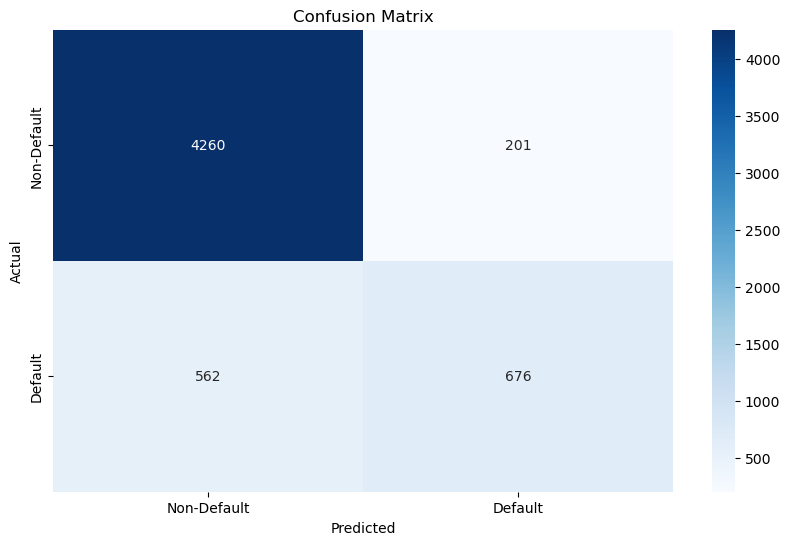

Confusion Matrix:

True Negatives: 4260
False Positives: 201
False Negatives: 562
True Positives: 676


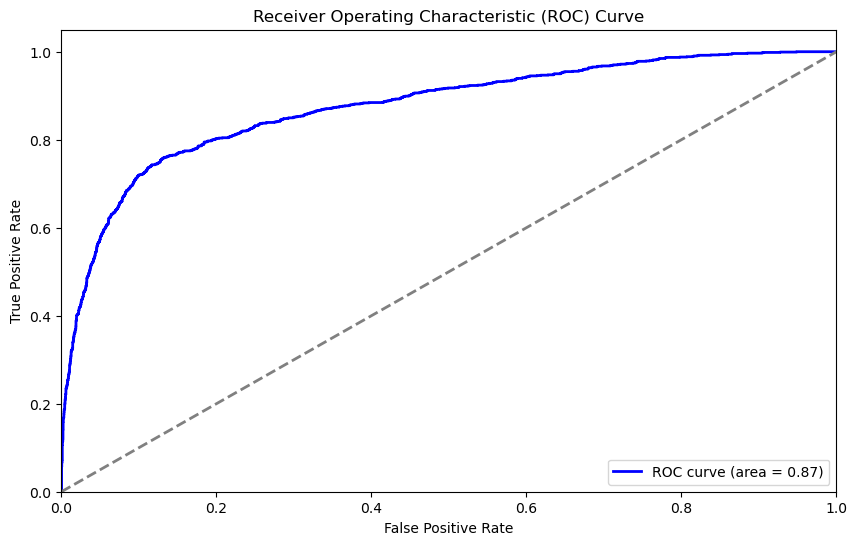

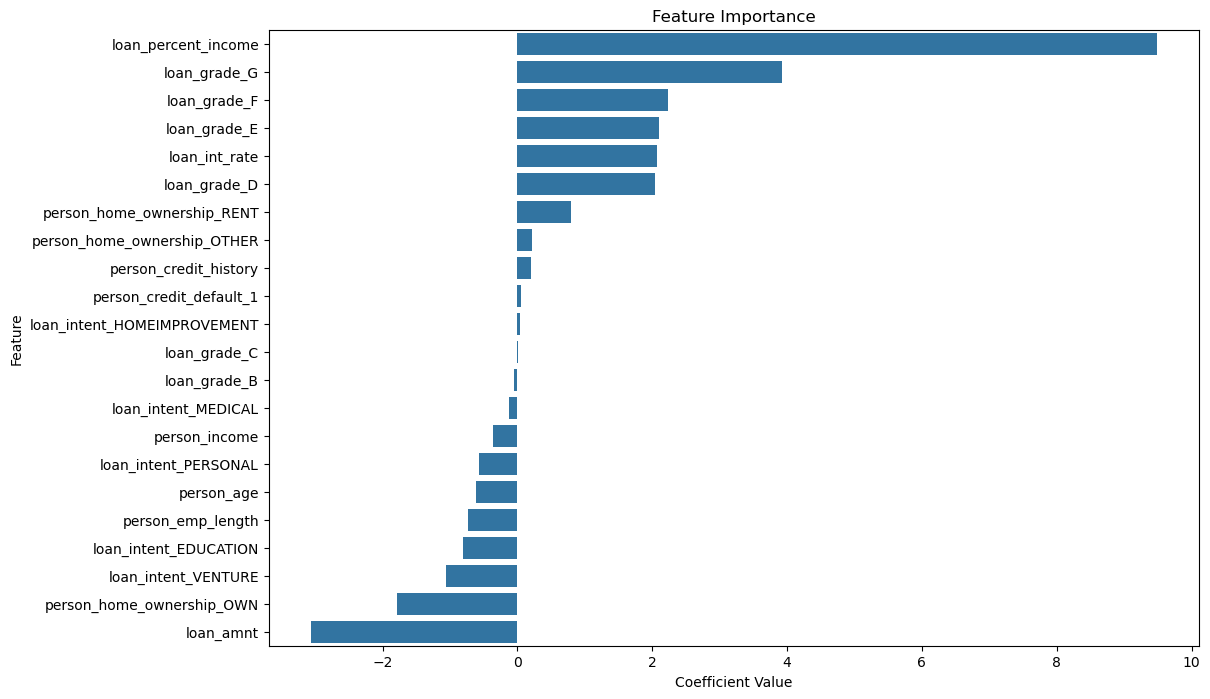

In [10]:
# Unbalanced Model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit logistic regression model on training data
model = LogisticRegression( random_state=33)
model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = model.predict(X_test_scaled)

# Evaluate model performance
print(classification_report(y_test, y_pred))

# Calculate accuracy scores for training and test sets
train_accuracy = accuracy_score(y_train, model.predict(X_train_scaled))
test_accuracy = accuracy_score(y_test, model.predict(X_test_scaled))

# Print accuracy scores
print(f'Training Accuracy: {train_accuracy:.2f}')
print(f'Test Accuracy: {test_accuracy:.2f}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Default', 'Default'], yticklabels=['Non-Default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
# Extract values
tn, fp, fn, tp = cm.ravel()

# Print values in a readable format
print(f"Confusion Matrix:\n")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")
# ROC Curve
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Feature Importance (coefficients for logistic regression)
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': model.coef_[0]})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

              precision    recall  f1-score   support

           0       0.93      0.83      0.88      4461
           1       0.56      0.79      0.66      1238

    accuracy                           0.82      5699
   macro avg       0.75      0.81      0.77      5699
weighted avg       0.85      0.82      0.83      5699

Training Accuracy: 0.81
Test Accuracy: 0.82


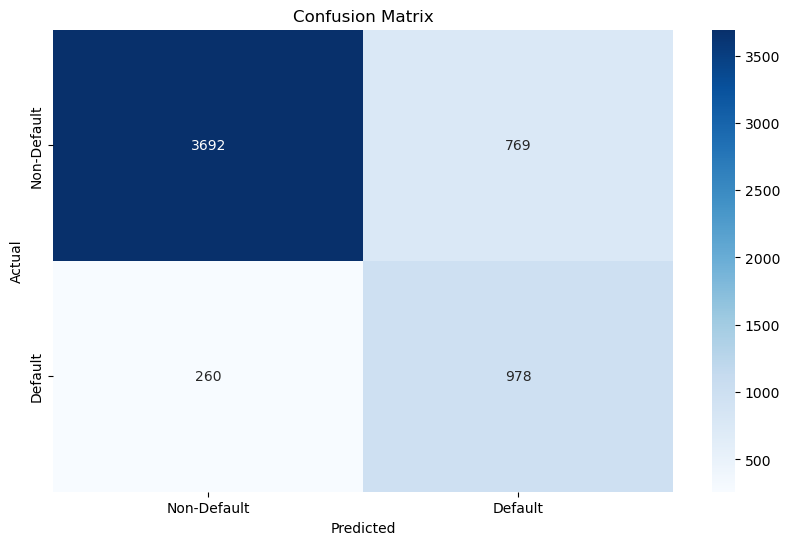

Confusion Matrix:

True Negatives: 3692
False Positives: 769
False Negatives: 260
True Positives: 978


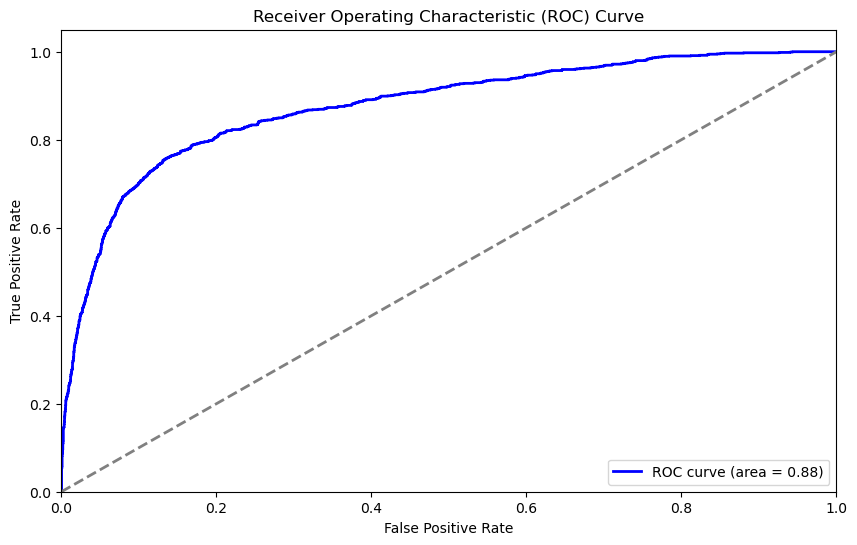

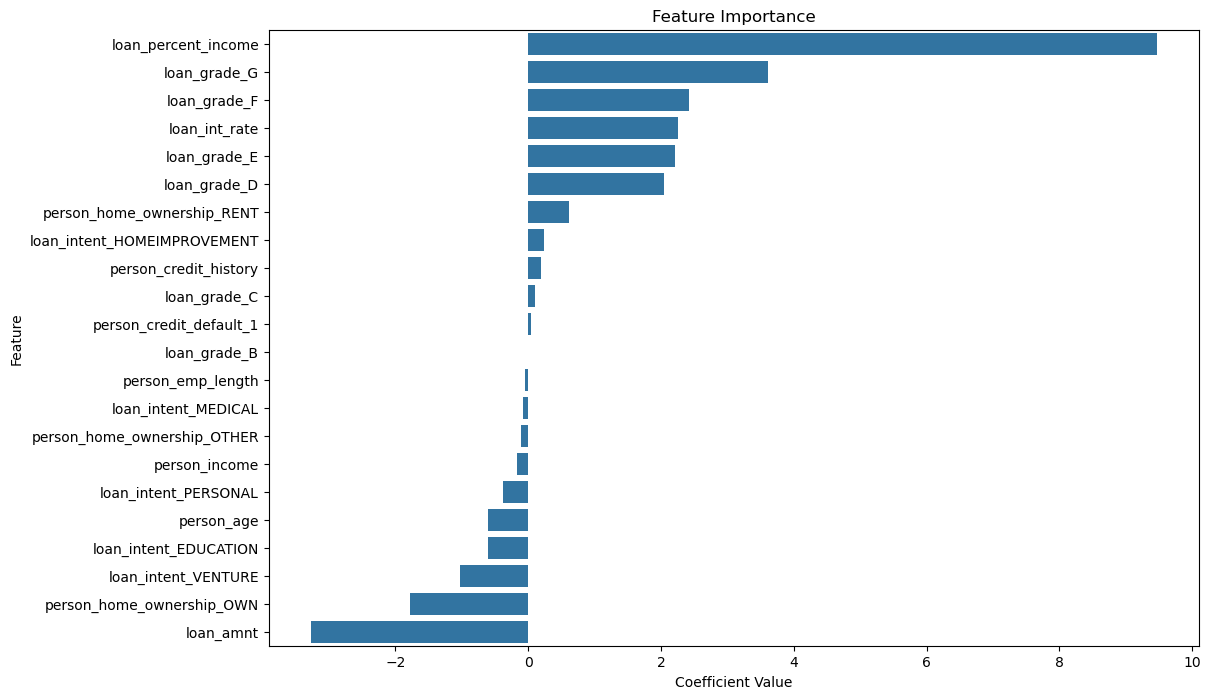

In [11]:
# Balanced Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Fit logistic regression model on training data
model = LogisticRegression(class_weight='balanced', random_state=33)
model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = model.predict(X_test_scaled)

# Evaluate model performance
print(classification_report(y_test, y_pred))

# Calculate accuracy scores for training and test sets
train_accuracy = accuracy_score(y_train, model.predict(X_train_scaled))
test_accuracy = accuracy_score(y_test, model.predict(X_test_scaled))

# Print accuracy scores
print(f'Training Accuracy: {train_accuracy:.2f}')
print(f'Test Accuracy: {test_accuracy:.2f}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Default', 'Default'], yticklabels=['Non-Default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
# Extract values
tn, fp, fn, tp = cm.ravel()

# Print values in a readable format
print(f"Confusion Matrix:\n")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")
# ROC Curve
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Feature Importance (coefficients for logistic regression)
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': model.coef_[0]})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

### Insights and Conclusion

In the context of loan risk assessment, identifying potential defaulters (true positives) is crucial for minimizing financial losses. The balanced model’s higher recall ensures that fewer default cases are missed, aligning more closely with the business goal of risk mitigation.This preference for the **balanced model** underscores its effectiveness in prioritizing the detection of default cases, thereby enhancing the overall risk management strategy.

Both models demonstrate limitations in achieving high accuracy and precision simultaneously. Considering these results, further exploration with alternative modeling approaches should be explored to improve predictive performance.

Looking ahead, while resampling and SMOTE approaches could potentially refine logistic regression accuracy in future applications, for this project, we explored alternative methods such as K-Nearest Neighbors (KNN) and forest classification to broaden our analytical approach and insights.